# Optically-dark short GRBs

## Imports/loading/setup

In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, importlib, seaborn as sns, astropy.units as u

from astropy.io import votable, ascii
from astropy.coordinates import SkyCoord
from gdpyc.core import GasMap, DustMap
from scipy import interpolate, stats, optimize

from code.xrt import XRT_lightcurve, get_photonIndex, get_temporalIndex, get_columnDensity
from code.uncertainty import AsymmetricUncertainty, UncertaintyArray

#calc_code = importlib.import_module("legacy.Calculation Code.calc_beta_ox")
#graph_code = importlib.import_module("legacy.Graphing Code.Graphing_Beta_OX")

Main code has been moved to [`pipeline.ipynb`](./pipeline.ipynb). Running the cell below will perform the entire analysis and output the list of dark sGRBs.

In [1]:
%run pipeline.ipynb

Finished xray.
Finished optical.
210323A	 3
200411A	 1
200219A	 2
191031D	 1
190719C	 5
181123B	 1
180727A	 1
180618A	 1
180204A	 2
170827A	 2
170822A	 7
170728B	 29
170127B	 1
161004A	 2
161001A	 1
160821B	 3
160624A	 2
160525B	 1
160408A	 1
151229A	 5
150831A	 1
150424A	 7
130912A	 2
120804A	 1
080503	 1
080123	 1
070714B	 3
070707	 1
060313	 3
060121	 5


## $\LaTeX$ table formatting

In [3]:
def round_scientific(number, places):
    return float(f"%.{places}e"%number)

sample_df = sGRBs[['GRB', 'TriggerNumber', 'BAT T90[sec]', 'Redshift', 'Beta_X', 'Beta_X_neg', 'Beta_X_pos', 'N_H (intrinsic)']].copy()
sample_df.loc[sample_df["Beta_X"].notna(),"B_x"] = [AsymmetricUncertainty(*row[['Beta_X', 'Beta_X_pos', 'Beta_X_neg']]) for i,row in sample_df.loc[sample_df["Beta_X"].notna(),:].iterrows()]
sample_df.loc[sample_df["N_H (intrinsic)"].notna(),"N_H (intrinsic)"] = [AsymmetricUncertainty(entry) for entry in sample_df.loc[sample_df["N_H (intrinsic)"].notna(),"N_H (intrinsic)"]]
sample_df.drop(['Beta_X', 'Beta_X_pos', 'Beta_X_neg'], axis=1, inplace=True)
sample_df.rename(columns={"B_x":"Beta_X","BAT T90[sec]":"T90","TriggerNumber":"Trigger"},inplace=True)

for i,row in sample_df.iterrows():
    bx = row["Beta_X"]
    nh = row["N_H (intrinsic)"]
    if pd.notna(nh):
#         rounded_nh = (round_scientific(number,3) for number in nh.items())
#         rounded_nh = AsymmetricUncertainty(*rounded_nh)
        sample_df.loc[i,"N_H (intrinsic)"] = AsymmetricUncertainty(round(nh.value/1e21,3),
                                                                   round(nh.plus/1e21,3),
                                                                   round(nh.minus/1e21,3))
    if pd.notna(bx):
        rounded_bx = (round(number,2) for number in bx.items())
        rounded_bx = AsymmetricUncertainty(*rounded_bx)
        sample_df.loc[i,"Beta_X"] = rounded_bx
table_str = sample_df.to_latex(index=False, columns=["GRB","Trigger","T90","Redshift","Beta_X","N_H (intrinsic)"],na_rep='---')

In [4]:
for line in table_str.split("\n")[4:-3]:
    grb,trig,t90,z,beta_orig,n_h_orig = line.split("&")
    n_h_orig = n_h_orig[:-2]
    if beta_orig.strip() != "---":
        beta = beta_orig
        beta = beta.replace(" (+","^{+")
        beta = beta.replace(", -","}_{-")
        beta = beta.replace(")","}")
        beta = beta.replace("±",r"\pm")
        table_str = table_str.replace(beta_orig," $"+beta.strip()+"$ ")
    if n_h_orig.strip() != "---":
        n_h = n_h_orig
        n_h = n_h.replace("(+","^{+")
        n_h = n_h.replace(", -","}_{-")
        n_h = n_h.replace(")","}")
        if "±" not in n_h:
            pass
#             print(n_h)
#             val,err = n_h.split()
#             n_h = "("+val+")"+err
        else:
            n_h = n_h.replace("±",r"\pm")
        table_str = table_str.replace(n_h_orig," $"+n_h.strip()+"$ ")
# table_str = table_str.replace("e+19",r"\times10^{19}")
# table_str = table_str.replace("e+20",r"\times10^{20}")
# table_str = table_str.replace("e+21",r"\times10^{21}")
# table_str = table_str.replace("e+22",r"\times10^{22}")
print(table_str)

\begin{tabular}{llllll}
\toprule
    GRB &                    Trigger &                  T90 &              Redshift &               Beta\_X &        N\_H (intrinsic) \\
\midrule
210413B &                    1043009 &                1.088 &                   --- &                  --- &                    --- \\
210410A &                    1042113 &                52.88 &                   --- & $0.45^{+0.18}_{-0.17}$ & $0.4 ^{+0.6}_{-0.4}$ \\
210323A &                    1038247 &                 1.12 &                   --- & $0.7 \pm 0.2$ & $1.76 ^{+1.02}_{-0.89}$ \\
210119A &                    1017711 &                 0.06 &                   --- &                  --- &                    --- \\
201221D &                    1014037 &                 0.16 &                 1.046 & $0.1^{+1.05}_{-0.47}$ & $0.0 ^{+26.8}_{-0.0}$ \\
201214B &                    1012872 &                  --- &                   --- &                  --- &                    --- \\
201006A &        

## *Swift*-XRT lightcurve/spectrum demo

In [5]:
burst = "051221A"
fluxdata = XRT_lightcurve(burst,sGRBs)
Gamma,mode = get_photonIndex(burst,sGRBs)
NH,mode = get_columnDensity(burst,sGRBs)

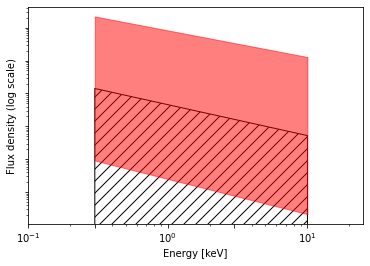

In [6]:
E_range = np.linspace(0.3,10,100)
spectrum = (E_range / 4.135667696e-18)**-(Gamma.value-1)
spec1 = (E_range / 4.135667696e-18)**-(Gamma.maximum-1)
spec2 = (E_range / 4.135667696e-18)**-(Gamma.minimum-1)

plt.fill_between(E_range,[0]*len(E_range),spectrum,fc="none",ec="k",hatch="//")
plt.fill_between(E_range,spec1,spec2,alpha=0.5,color="r")
plt.xlim(1e-1,25)
#plt.ylim(1e-16,1e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.1,0.3,1,3,10])
#plt.gca().set_xticklabels([0.1,0.3,1,3,10])
#plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density (log scale)")
plt.show()

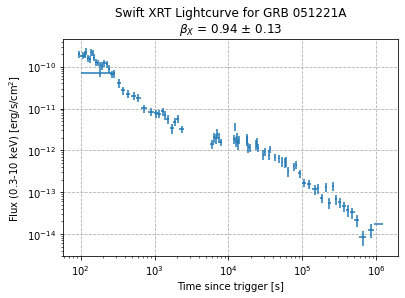

In [13]:
plt.errorbar(fluxdata.Time,fluxdata.Flux,xerr=np.array(fluxdata.Tneg,fluxdata.Tpos).T,
             yerr=np.array(fluxdata.Fluxneg,fluxdata.Fluxpos).T,linestyle="",capthick=0)
plt.xscale("log")
plt.yscale("log")
plt.title("Swift XRT Lightcurve for GRB %s\n$\\beta_X$ = %s" % (burst,Gamma-1))
plt.xlabel("Time since trigger [s]")
plt.ylabel("Flux (0.3-10 keV) [erg/s/cm$^2$]")
plt.grid(linestyle="--")

plt.show()

## Filter transmission calculations

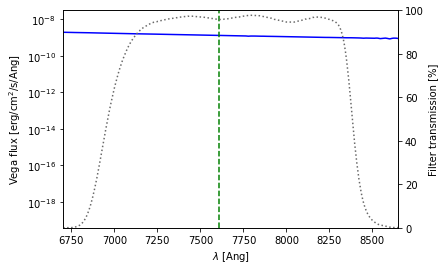

7606.226833366284

In [16]:
from code.fluxtools import effective_wavelength

# I_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/I.txt")
# rprime_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/r-band.txt").drop(columns=["T%"],axis=0)
# rprime_filter.columns = ["Wavelength","Transmission"]
# rprime_filter["Wavelength"] *= 10
# MOSFIRE_J = pd.read_table("https://www2.keck.hawaii.edu/inst/mosfire/data/filter/mosfire_J.txt",delimiter="   ").iloc[:,:2]
# MOSFIRE_J = MOSFIRE_J.rename(columns=dict(zip(MOSFIRE_J.columns,["Wavelength","Transmission"]))).apply(pd.to_numeric,errors="coerce").dropna()
# MOSFIRE_J["Wavelength"] *= 10000
# MOSFIRE_J["Transmission"] *= 100

# MOSFIRE_K = pd.read_table("https://www2.keck.hawaii.edu/inst/mosfire/data/filter/mosfire_K.txt",delimiter="   ",engine='python').iloc[:,:2]
# MOSFIRE_K = MOSFIRE_K.rename(columns=dict(zip(MOSFIRE_K.columns,["Wavelength","Transmission"]))).apply(pd.to_numeric,errors="coerce").dropna()
# MOSFIRE_K["Wavelength"] *= 10000
# MOSFIRE_K["Transmission"] *= 100

# REMIR_H = pd.read_csv("./data/REM/H.csv",header=None,names=["Wavelength","Transmission"])
# REMIR_H["Wavelength"] *= 10

LDSS3_i = pd.read_table("http://www.lco.cl/wp-content/uploads/telescopes/magellan/instruments/ldss3/filters-data/i01.txt",
                        header=None,names=["Wavelength","Transmission"])
LDSS3_i["Wavelength"] *= 10
effective_wavelength(LDSS3_i,dl=1,show_plot=True)

<AxesSubplot:xlabel='lambda_eff'>

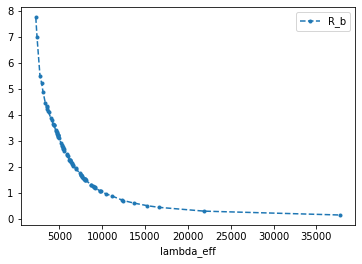

In [20]:
RbTable = pd.read_csv("./data/Rb.csv") # Table 6 from Schlafly & Finkbeiner (2011)
Rb = interpolate.interp1d(RbTable["lambda_eff"],RbTable["R_b"],fill_value="extrapolate") # function that takes a wavelength [Ang] and returns the corresponding R_b value

RbTable.drop([37,55,61,73],axis=0,inplace=True) # smoothing
RbTable.sort_values(by="lambda_eff",inplace=True) # sort in order of wavelength: UV -> IR
RbTable.plot(x="lambda_eff", y="R_b", marker=".", linestyle="--")

## Plot dark GRBs' lightcurves

3 0 0


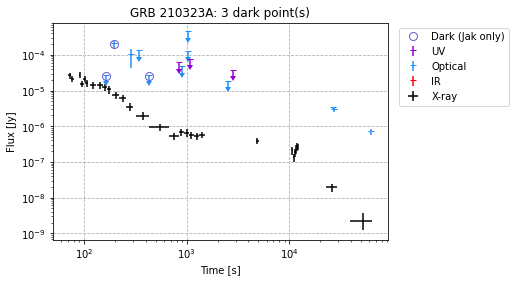

1 0 0


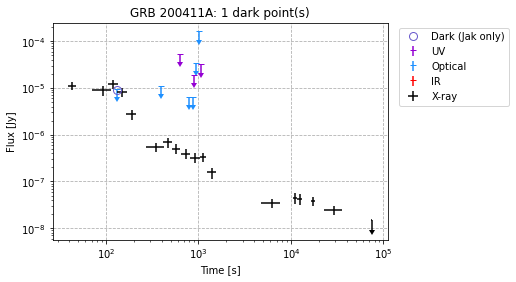

2 0 0


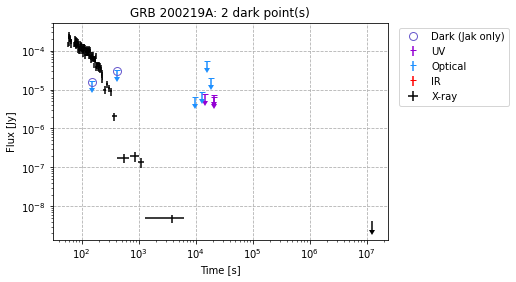

1 0 0


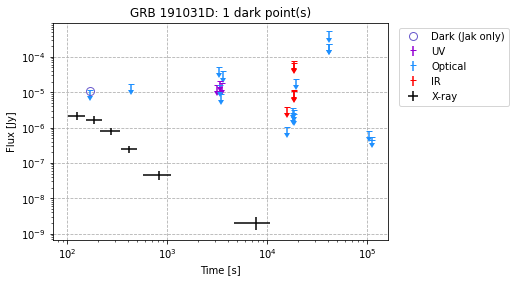

4 0 1


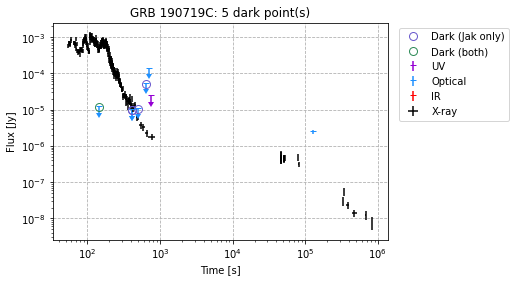

1 0 0


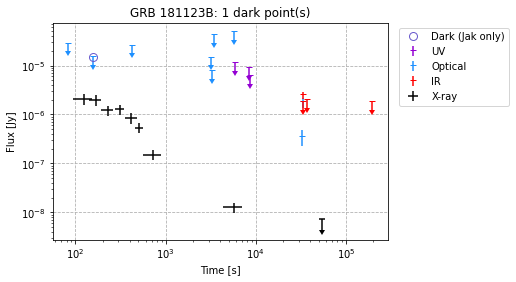

1 0 0


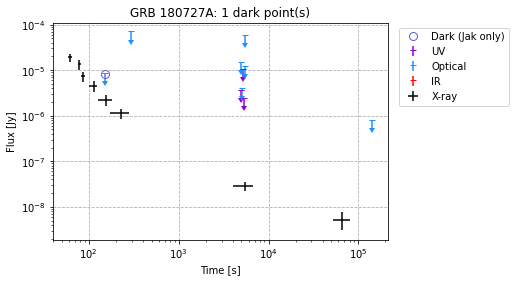

0 0 1


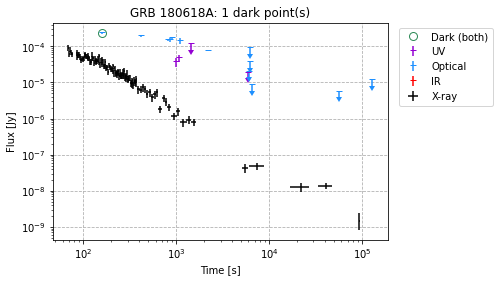

1 0 1


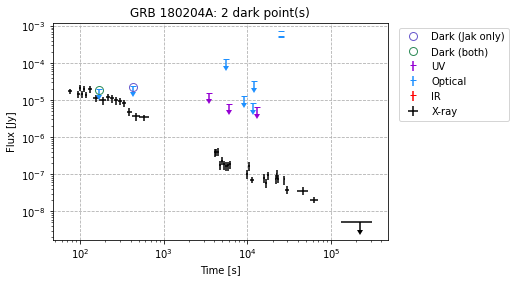

0 0 2


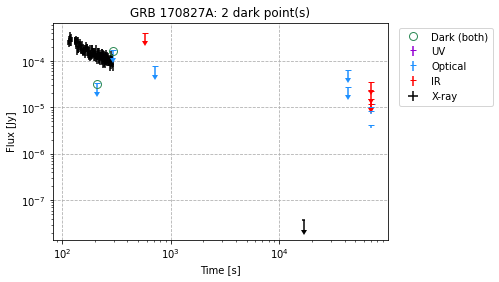

5 0 2


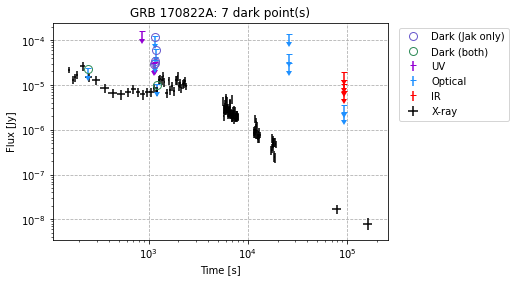

15 0 14


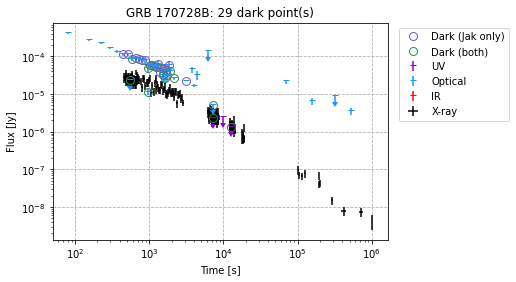

1 0 0


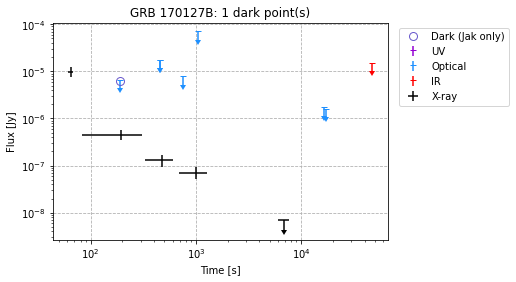

2 0 0


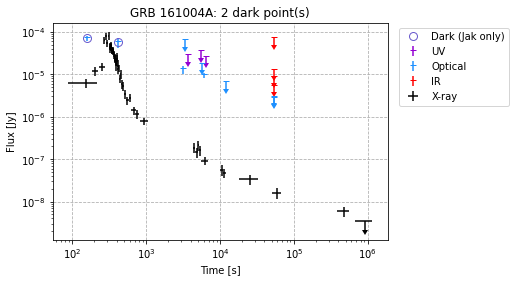

1 0 0


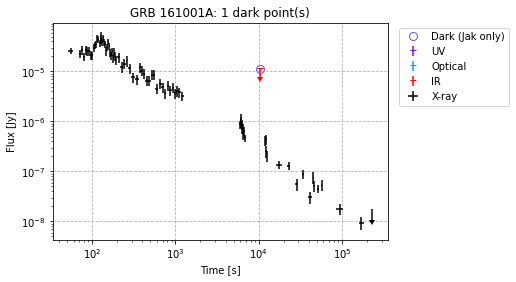

0 0 3


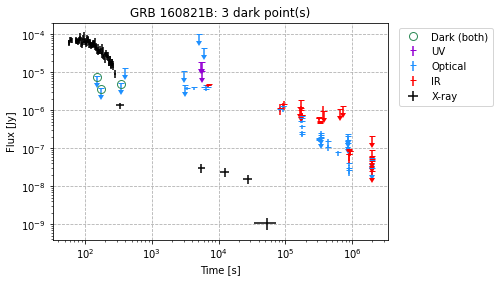

1 0 1


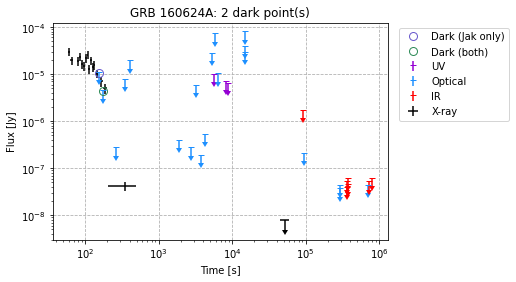

1 0 0


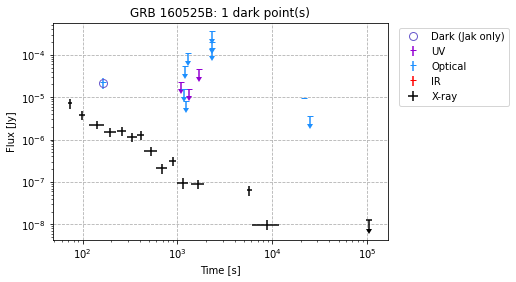

1 0 0


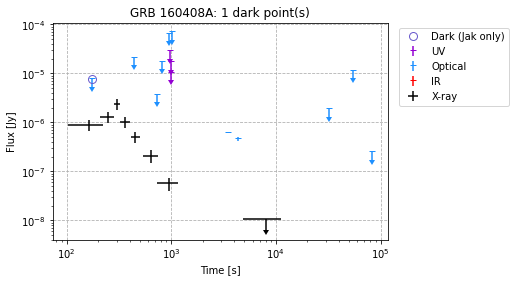

3 0 2


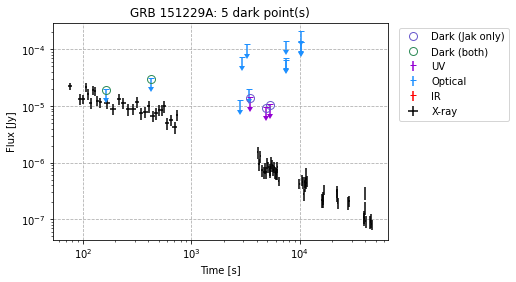

1 0 0


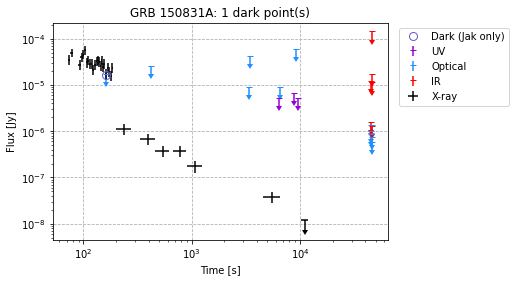

3 0 4


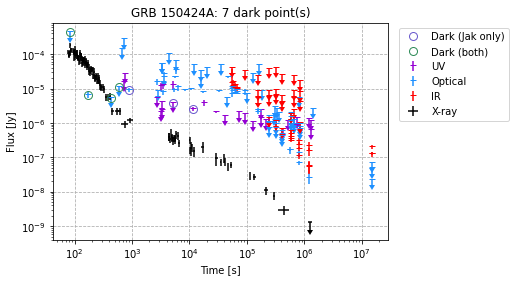

2 0 0


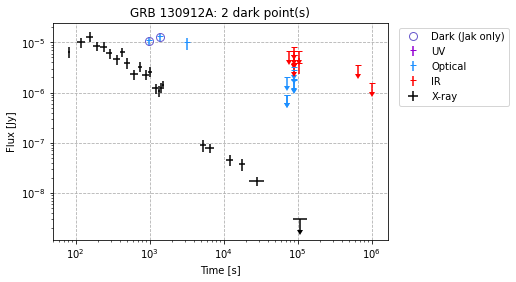

0 0 1


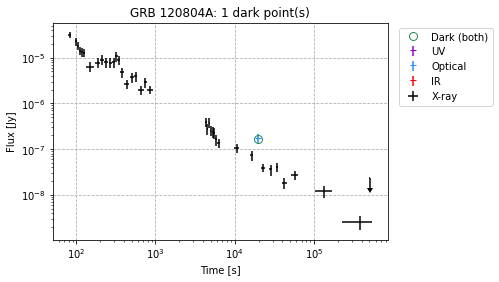

1 0 0


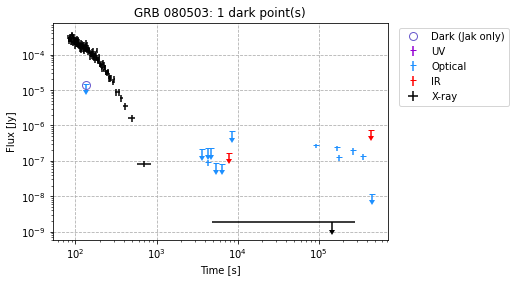

0 0 1


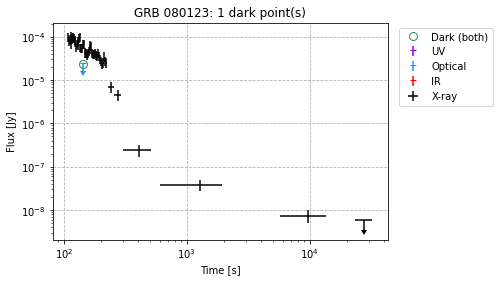

3 0 0


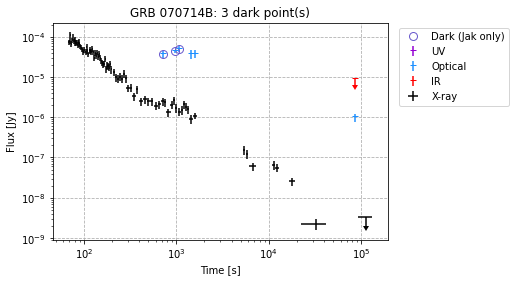

0 0 1


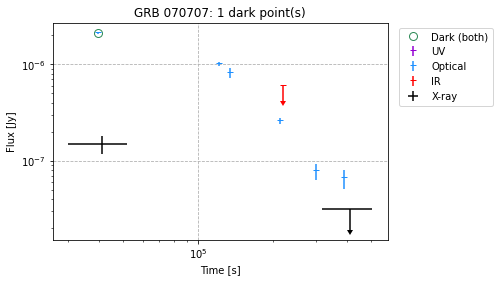

3 0 0


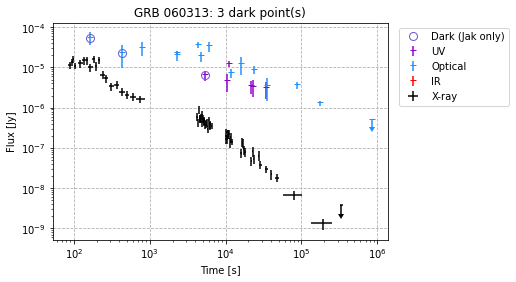

1 0 4


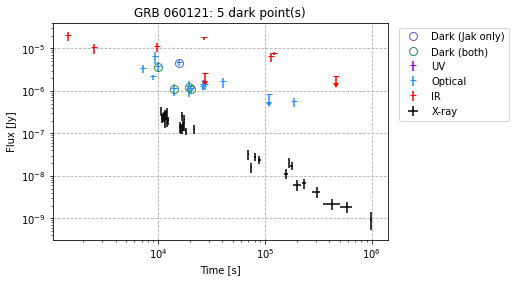

In [21]:
for grb in close_times["GRB"].unique():
    fig, ax = plt.subplots()

    subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()
    dark_points = close_times[close_times["GRB"]==grb]

    subset.loc[:,"band"] = ["UV" if wavelength<3000 else "IR" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
    bands = {"UV":["darkviolet","$\lambda<3000$ Å"],"Optical":["dodgerblue","$\lambda<3000$ Å"],"IR":"red"}
    for band,info in bands.items():
        subsubset = subset[subset["band"]==band]
        neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
        pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
        ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                    marker="$—$",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                    uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                    lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)

    subset = xrt_data.loc[xrt_data["GRB"]==grb]
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
    ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subset["SpecFlux"]],
                lolims=[np.isinf(point.plus) for point in subset["SpecFlux"]],
                linestyle="",capthick=0,color="k",label="X-ray")

    jak = dark_points[dark_points["Jak_dark"] & ~dark_points["vdH_dark"]]
    vdh = dark_points[dark_points["vdH_dark"] & ~dark_points["Jak_dark"]]
    both = dark_points[dark_points["Jak_dark"] & dark_points["vdH_dark"]]
    print(len(jak),len(vdh),len(both))
    
    if len(jak)>0:
        ax.plot(jak["t_o"],[flux.value for flux in jak["F_o"]],
            marker="o",markersize=8,mfc="none",mec="slateblue",
            linestyle="",label="Dark (Jak only)")
    if len(vdh)>0:
        ax.plot(vdh["t_o"],[flux.value for flux in vdh["F_o"]],
            marker="o",markersize=8,mfc="none",mec="goldenrod",
            linestyle="",label="Dark (vdH only)")
    if len(both)>0:
        ax.plot(both["t_o"],[flux.value for flux in both["F_o"]],
            marker="o",markersize=8,mfc="none",mec="seagreen",
            linestyle="",label="Dark (both)")
    
    ax.set(xscale="log",yscale="log",xlabel="Time [s]",ylabel=f"Flux [Jy]",title=f"GRB {grb} lightcurve")
    ax.legend(loc="upper left",bbox_to_anchor=(1.02,1))
    ax.grid(linestyle="--")
    
    plt.title("GRB "+grb+": "+str(close_times["GRB"].tolist().count(grb))+" dark point(s)")
    fig.savefig(f"./products/dark lightcurves/{grb}.png",dpi=300,transparent=False,facecolor="white",bbox_inches="tight")
    plt.show()

In [22]:
def interp_xray_flux(grb,time):
    lightcurve = xrt_data[xrt_data["GRB"]==grb]
    time_series = [lightcurve.loc[i,"Time"] for i in lightcurve.index if np.isfinite(lightcurve.loc[i,"SpecFlux"].minus)]
    flux_series = [Fx.value for Fx in lightcurve["SpecFlux"] if np.isfinite(Fx.minus)]
    interp_func = interpolate.interp1d(time_series,flux_series)
    return interp_func(time)

def interp_B_ox(optical_index):
    grb = all_optical.loc[optical_index,"GRB"]
    t_o = all_optical.loc[optical_index,"Time (s)"]
    F_o = all_optical.loc[optical_index,"Flux (Jy)"]
    print("B_x",all_beta_x[all_beta_x["GRB"]==grb])
    print(grb,t_o,F_o)
    F_x = interp_xray_flux(grb,t_o)
    nu_o = 299792458/float(all_optical.loc[optical_index,"λ_eff"]/1e10)
    return -np.log10(F_x/F_o)/np.log10(nu_x/nu_o)

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
11,210410A,1042113,Johnson,RATIR,r,6149.31,31518.0,23.79,0.3,GCN 29784,0.05,0.114819,23.79 ± 0.3,1.2301383194065202e-06 ± 3.3989977879034427e-07


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


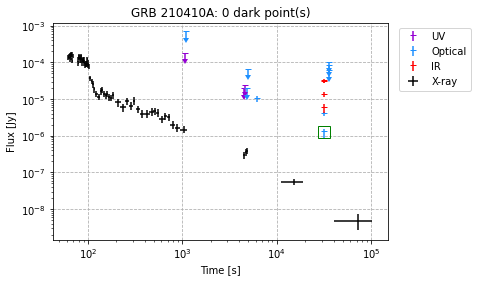

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
37,210323A,1038247,Gemini North,GMOS,r,6224.52,62208.0,24.6,0.2,GCN 29720,0.131,0.296007,24.6 ± 0.2,6.893331537774699e-07 ± 1.2697985951956597e-07


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


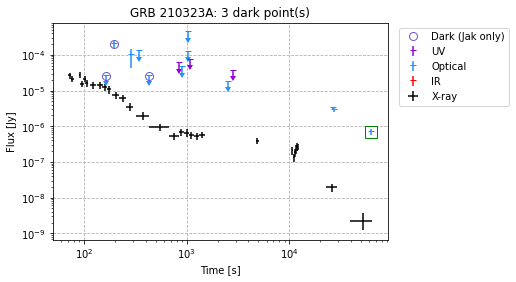

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
54,201221D,1014037,NOT,ALFOSC,r,6141.12,6012.0,23.1,0.3,GCN 29117,0.02,0.046046,23.1 ± 0.3,2.1799401461112093e-06 ± 6.023397220865919e-07
60,201221D,1014037,Discovery,LMI,r,6141.12,36396.0,23.9,0,GCN 29128,0.02,0.046046,23.9 ± 0.0,1.0433849533910372e-06 ± 0.0
61,201221D,1014037,Discovery,LMI,i,7457.89,36396.0,23.7,0,GCN 29128,0.02,0.034223,23.7 ± 0.0,1.2408392388138238e-06 ± 0.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


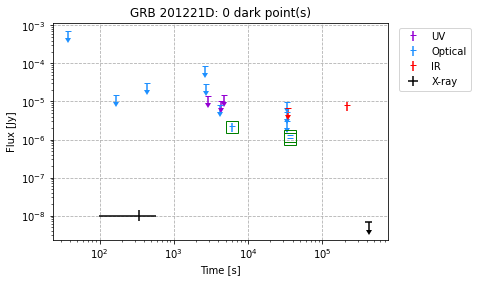

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
96,201006A,998907,Discovery,LMI,i,7457.89,124416.0,23.8,3-sigma,GCN 28572,1.27,2.173172,"23.8 (+inf, -0.0)","8.1151186884704e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


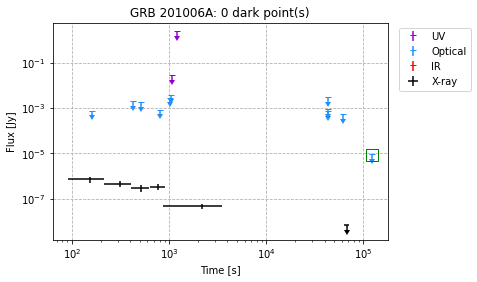

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
138,200522A,973628,Gemini North,GMOS,r,6224.52,269568.0,26.00,0.04,arXiv:2012.00026,0.03,0.067788,26.0 ± 0.04,1.5386555967725742e-07 ± 5.668616704608619e-09
139,200522A,973628,Hubble,WFC3,F125W,12364.65,299808.0,24.90,0.08,arXiv:2012.00026,0.03,0.021679,24.9 ± 0.08,4.0616070630785857e-07 ± 2.992702680654105e-08
140,200522A,973628,Hubble,WFC3,F125W,12364.65,304128.0,24.53,0.15,2021ApJ...906..127F,0.03,0.021679,24.53 ± 0.15,5.710812555030189e-07 ± 7.889779114857451e-08
142,200522A,973628,Hubble,WFC3,NaN,15279.08,311040.0,23.70,NaN,GCN 27826,0.03,0.015330,"23.7 (+nan, -nan)","1.2194343881858644e-06 (+nan, -nan)"
143,200522A,973628,Hubble,WFC3,F125W,12364.65,311040.0,23.80,0.3,GCN 27827,0.03,0.021679,23.8 ± 0.3,1.1186594754812014e-06 ± 3.090970358855463e-07
144,200522A,973628,Hubble,WFC3,F160W,15279.08,311904.0,24.71,0.07,arXiv:2012.00026,0.03,0.015330,24.71 ± 0.07,4.81014798821612e-07 ± 3.101217014773287e-08
145,200522A,973628,Hubble,WFC3,F160W,15279.08,316224.0,24.61,0.15,2021ApJ...906..127F,0.03,0.015330,24.61 ± 0.15,5.274222389300992e-07 ± 7.286607510443941e-08
146,200522A,973628,Hubble,WFC3,F125W,12364.65,1410048.0,27.20,3-sigma,arXiv:2012.00026,0.03,0.021679,"27.2 (+inf, -0.0)","4.883125719330247e-08 (+0.0, -inf)"
147,200522A,973628,Hubble,WFC3,F125W,12364.65,1415232.0,27.50,3-sigma,2021ApJ...906..127F,0.03,0.021679,"27.5 (+inf, -0.0)","3.704229666732184e-08 (+0.0, -inf)"
148,200522A,973628,Hubble,WFC3,NaN,12364.65,1416960.0,26.80,<3-sigma,GCN 27904,0.03,0.021679,"26.8 (+inf, -0.0)","7.058264120272258e-08 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


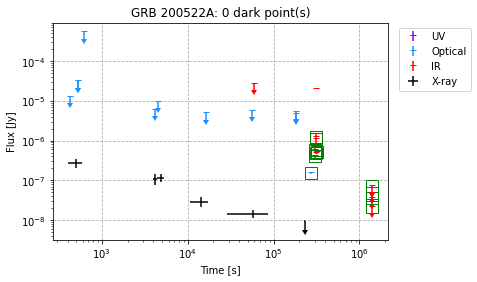

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
189,191031D,932608,MMT,Binospec,r,NaN,15516.0,23.50,3-sigma,GCN 26134,0.08,NaN,"23.5 (+inf, -0.0)","nan (+nan, -nan)"
190,191031D,NaN,MMT,Binospec,r,6122.940,15552.0,24.10,3-sigma,Rastinejad,0.08,0.185232,"24.1 (+inf, -0.0)","9.865497528567421e-07 (+0.0, -inf)"
193,191031D,NaN,HJT,RATIR,i,7531.293,18144.0,23.10,3-sigma,Rastinejad,0.08,0.134263,"23.1 (+inf, -0.0)","2.364456394798117e-06 (+0.0, -inf)"
195,191031D,932608,Johnson,RATIR,i,7531.290,18252.0,23.17,3-sigma,GCN 26121,0.08,0.134263,"23.17 (+inf, -0.0)","2.2168246563739915e-06 (+0.0, -inf)"
204,191031D,NaN,MMT,Binospec,r,6122.940,102816.0,24.40,3-sigma,Rastinejad,0.08,0.185232,"24.4 (+inf, -0.0)","7.483745191677094e-07 (+0.0, -inf)"
205,191031D,NaN,Gemini-N,GMOS,r,6224.520,112320.0,24.80,3-sigma,Rastinejad,0.08,0.180768,"24.8 (+inf, -0.0)","5.156242975052886e-07 (+0.0, -inf)"
206,191031D,932608,Gemini North,GMOS,r,6224.520,112320.0,25.00,NaN,GCN 26147,0.08,0.180768,"25.0 (+nan, -nan)","4.2887761016516436e-07 (+nan, -nan)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


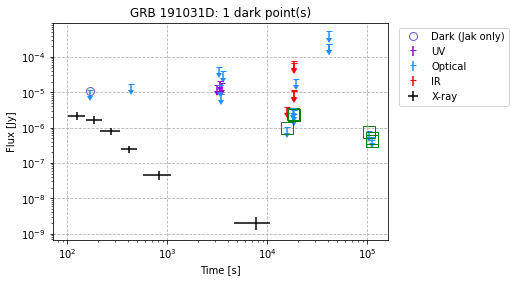

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
214,190719C,915381,NOT,ALFOSC,NaN,6141.12,129686.4,23.03,0.12,GCN 25144,0.04,0.092092,23.03 ± 0.12,2.4258441175067434e-06 ± 2.681142001391195e-07


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


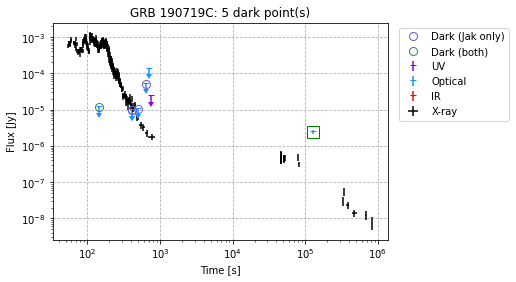

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


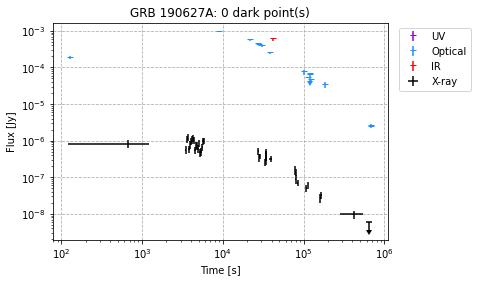

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
281,181126A,NaN,Gemini-N,GMOS,z,9571.59,15552.0,25.3,3-sigma,Rastinejad,0.07,0.078140,"25.3 (+inf, -0.0)","2.9599353322133564e-07 (+0.0, -inf)"
282,181126A,NaN,Keck I,MOSFIRE,Ks,21354.70,15552.0,23.6,3-sigma,Rastinejad,0.07,0.022192,"23.6 (+inf, -0.0)","1.3455604272546054e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


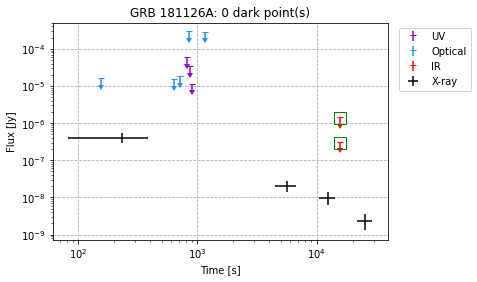

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
294,181123B,873186,Gemini North,GMOS,i,7713.830,32832.0,25.10,0.39,2020ApJ...898L..32P,0.03,0.048439,25.1 ± 0.39,3.4625970047727575e-07 ± 1.2437761824127513e-07
295,181123B,873186,Gemini North,GMOS,i,7713.830,33120.0,23.32,0.25,GCN 23439,0.03,0.048439,23.32 ± 0.25,1.7840291615019164e-06 ± 4.1078789527409804e-07
297,181123B,873186,Keck,MOSFIRE,J,12431.167,33120.0,23.30,3-sigma,GCN 23461,0.03,0.021449,"23.3 (+inf, -0.0)","1.7725800080287376e-06 (+0.0, -inf)"
298,181123B,873186,Keck,MOSFIRE,J,12431.167,37152.0,23.20,inf,2020ApJ...898L..32P,0.03,0.021449,"23.2 (+inf, -0.0)","1.943595329722827e-06 (+0.0, -inf)"
300,181123B,873186,MMT,MMIRS,J,12452.990,196128.0,23.30,inf,2020ApJ...898L..32P,0.03,0.021373,"23.3 (+inf, -0.0)","1.77245673911448e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


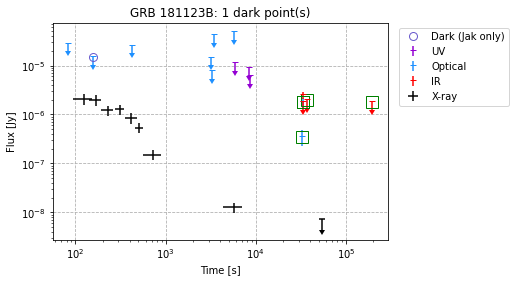

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
302,180805B,NaN,ESO,HAWK-I,J,12522.31,60480.0,24.4,3-sigma,Rastinejad,0.02,0.014117,"24.4 (+inf, -0.0)","6.39253659007889e-07 (+0.0, -inf)"
303,180805B,NaN,NTT,EFOSC2,i,7944.87,63936.0,25.0,3-sigma,Rastinejad,0.02,0.030951,"25.0 (+inf, -0.0)","3.7359968177692304e-07 (+0.0, -inf)"
304,180805B,NaN,Magellan-Baade,IMACS,r,6463.84,69120.0,24.2,3-sigma,Rastinejad,0.02,0.042990,"24.2 (+inf, -0.0)","7.892638862875304e-07 (+0.0, -inf)"
305,180805B,NaN,ESO,FORS2,R,6425.70,70848.0,25.7,3-sigma,Rastinejad,0.02,0.043387,"25.7 (+inf, -0.0)","1.9832654704498356e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


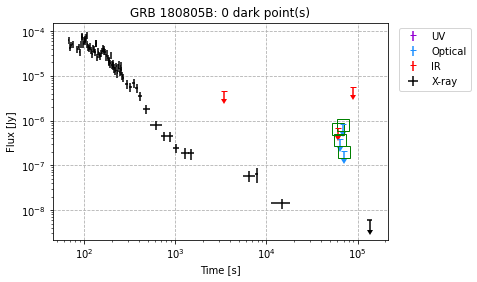

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
317,180727A,NaN,Magellan-Clay,LDSS3,i,7606.23,143424.0,24.2,3-sigma,Rastinejad,0.02,0.033035,"24.2 (+inf, -0.0)","7.820601527779771e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


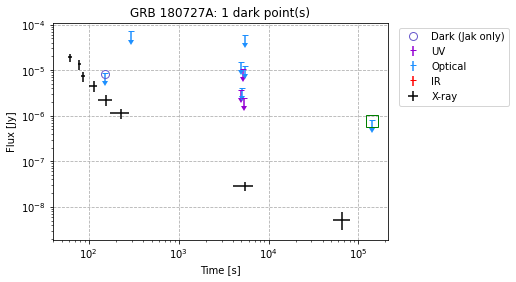

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
557,180418A,826428,Johnson,RATIR,r,6149.31,85608.0,23.63,0.22,GCN 22664,0.02,0.045928,23.63 ± 0.22,1.3378189033322842e-06 ± 2.7107888402659333e-07
558,180418A,826428,Johnson,RATIR,i,7531.29,85608.0,23.14,0.16,GCN 22664,0.02,0.033566,23.14 ± 0.16,2.0770766450139916e-06 ± 3.060893260681794e-07
559,180418A,826428,Gemini North,GMOS,r,6224.52,86400.0,23.86,0.13,2021ApJ...912...95R,0.02,0.045192,23.86 ± 0.13,1.0816905366730786e-06 ± 1.2951559425876032e-07
560,180418A,826428,Gemini North,GMOS,i,7713.83,96768.0,23.85,0.08,2021ApJ...912...95R,0.02,0.032293,23.85 ± 0.08,1.078806072312872e-06 ± 7.948936897085041e-08
561,180418A,826428,Gemini North,GMOS,z,9571.59,98496.0,23.37,0.29,2021ApJ...912...95R,0.02,0.022326,23.37 ± 0.29,1.6632461512941445e-06 ± 4.442528320981555e-07
562,180418A,826428,Gemini North,GMOS,g,4647.53,101952.0,24.50,0.31,2021ApJ...912...95R,0.02,0.067285,24.5 ± 0.31,6.122663740405936e-07 ± 1.7481463280011607e-07


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


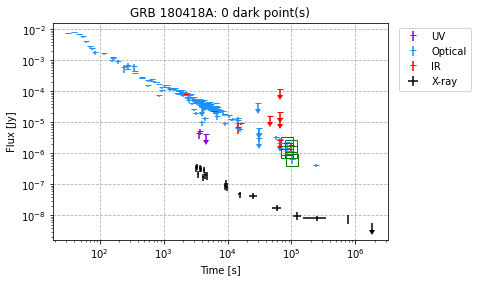

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
577,180402A,821103,Johnson,RATIR,r,6149.31,3222.0,23.3,3-sigma,GCN 22582,0.77,1.768216,"23.3 (+inf, -0.0)","8.857533477261686e-06 (+0.0, -inf)"
578,180402A,821103,Johnson,RATIR,i,7531.29,3222.0,23.3,3-sigma,GCN 22582,0.77,1.292279,"23.3 (+inf, -0.0)","5.713967703558705e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


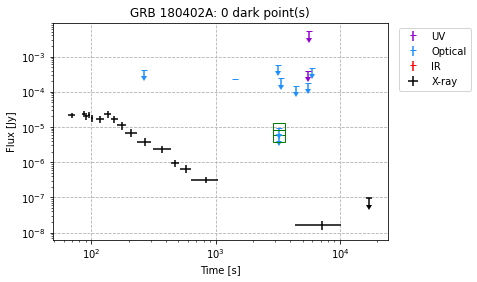

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
623,170822A,768939,Johnson,RATIR,r,6149.31,93294.0,23.37,3-sigma,GCN 21655,0.17,0.390385,"23.37 (+inf, -0.0)","2.334427674242859e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


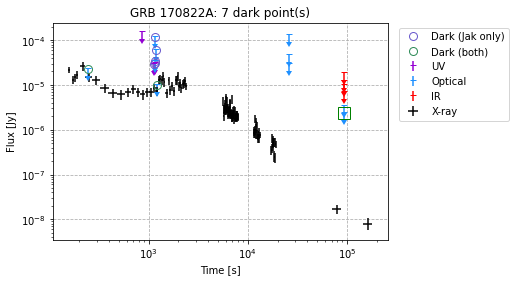

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
666,170728B,765130,Swift,UVOT,UVW1,2684.14,9965.0,23.11,3-sigma,GCN 21399,0.03,0.172156,"23.110000000000003 (+inf, -0.0)","2.425987494208703e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


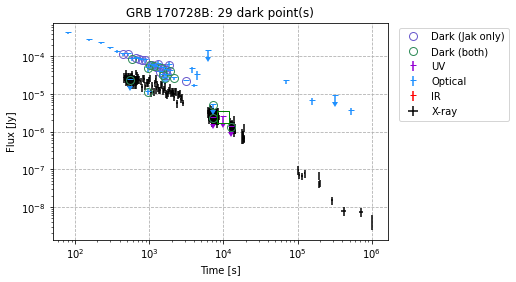

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
734,170428A,NaN,MMT,MMTCam,i,7591.2,265248.0,23.7,3-sigma,Rastinejad,0.06,0.099424,"23.7 (+inf, -0.0)","1.3176369133191583e-06 (+0.0, -inf)"
735,170428A,NaN,MMT,MMTCam,i,7591.2,352512.0,24.4,3-sigma,Rastinejad,0.06,0.099424,"24.4 (+inf, -0.0)","6.915056820103782e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


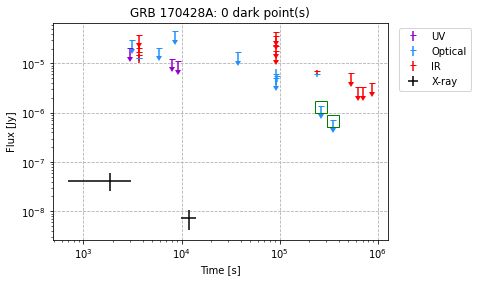

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
748,170127B,NaN,NOT,ALFSOC,r,6330.81,16416.0,23.4,3-sigma,Rastinejad,0.02,0.044047,"23.4 (+inf, -0.0)","1.6506123351826636e-06 (+0.0, -inf)"
749,170127B,735331,NOT,ALFOSC,r,6141.12,17028.0,23.5,?,GCN 20549,0.02,0.046046,"23.5 (+inf, -0.0)","1.5081501078292918e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


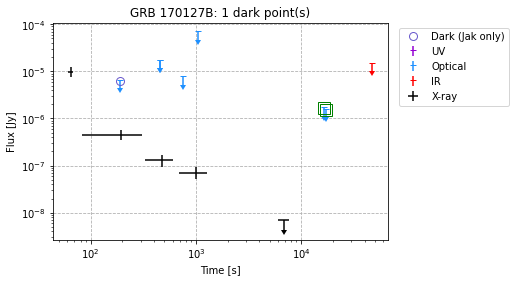

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
767,161104A,720568,Swift,UVOT,UVM2,2245.78,4879.0,23.39,3-sigma,GCN 20130,0.02,0.155467,"23.39 (+inf, -0.0)","1.8459202303851659e-06 (+0.0, -inf)"
770,161104A,720568,Gemini South,GMOS,r,6244.66,61200.0,24.60,NaN,GCN 20137,0.02,0.044971,"24.6 (+nan, -nan)","5.470345724447429e-07 (+nan, -nan)"
771,161104A,720568,La Silla,GROND,r',6097.98,64800.0,24.10,0.1,GCN 20132,0.02,0.046668,24.1 ± 0.1,8.683471997142399e-07 ± 7.99777327042053e-08


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


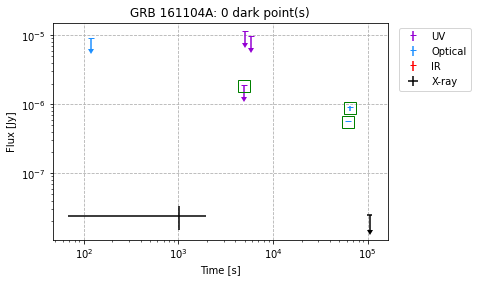

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


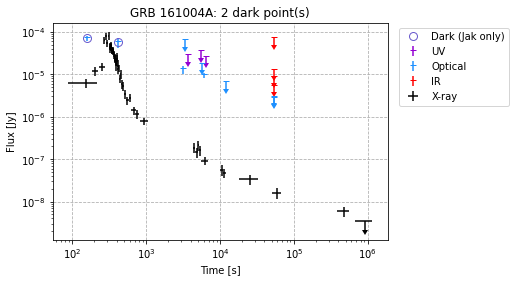

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
802,160927A,713782,NOT,ALFOSC,r,6141.12,12816.0,23.07,0.1,GCN 19960,0.08,0.184183,23.07 ± 0.1,2.5450688249067958e-06 ± 2.3440950147497043e-07
803,160927A,713782,La Silla,GROND,r',6097.98,20088.0,23.90,0.4,GCN 19959,0.08,0.186672,23.9 ± 0.4,1.1876675362975848e-06 ± 4.3755289032188544e-07
804,160927A,713782,Magellan/Baade,IMACS,r,6463.84,21384.0,23.84,0.21,GCN 19964,0.08,0.171960,23.84 ± 0.21,1.2382552547123352e-06 ± 2.394997996290621e-07
805,160927A,713782,GTC,OSIRIS,r,6350.01,95472.0,25.30,0.2,GCN 20004,0.08,0.175407,25.3 ± 0.2,3.237344710251509e-07 ± 5.963409336566604e-08


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


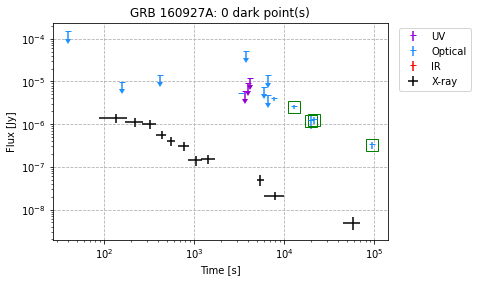

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
841,160821B,709357,TNG,DOLoRes,g,4672.08,82080.000,24.02,0.16,2019ApJ...883...48L,0.05,0.167420,24.02 ± 0.16,1.0447060306834353e-06 ± 1.5395357010001014e-07
842,160821B,709357,GTC,CIRCE,H,16181.36,82944.000,23.83,0.35,2019ApJ...883...48L,0.05,0.023414,23.83 ± 0.35,1.0899130102335851e-06 ± 3.513464430033768e-07
843,160821B,709357,WHT,ACAM,r,6256.18,91584.000,23.82,0.07,2019ApJ...883...48L,0.05,0.112110,23.82 ± 0.07,1.1936310126142043e-06 ± 7.695623533306393e-08
844,160821B,709357,WHT,ACAM,r,6256.18,92448.000,23.83,0.25,2019MNRAS.489.2104T,0.05,0.112110,23.83 ± 0.25,1.182687737712857e-06 ± 2.723239154524477e-07
845,160821B,709357,WHT,ACAM,z,9103.78,93312.000,23.60,0.15,2019ApJ...883...48L,0.05,0.060915,23.6 ± 0.15,1.394415220714856e-06 ± 1.926455820397218e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,160821B,709357,Hubble,WFC3,NaN,11203.65,2002826.304,28.00,inf,2018ApJ...857..128J,0.05,0.043824,"28.0 (+inf, -0.0)","2.385371202170175e-08 (+0.0, -inf)"
898,160821B,709357,Hubble,WFC3,F606W,5780.85,2004480.000,27.34,inf,2019ApJ...883...48L,0.05,0.126412,"27.34 (+inf, -0.0)","4.727059888759895e-08 (+0.0, -inf)"
899,160821B,709357,Hubble,WFC3,F160W,15279.08,2005948.800,25.70,inf,2019MNRAS.489.2104T,0.05,0.025551,"25.7 (+inf, -0.0)","1.9509519086297314e-07 (+0.0, -inf)"
900,160821B,709357,Hubble,WFC3,F160W,15279.08,2007072.000,27.21,inf,2019ApJ...883...48L,0.05,0.025551,"27.21 (+inf, -0.0)","4.8556409354100935e-08 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


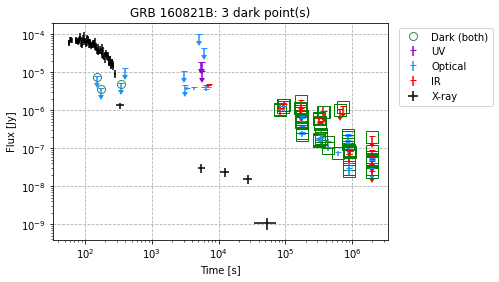

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
957,160624A,701288,Gemini North,GMOS,r,6224.52,1900.8,25.1,3-sigma,arXiv:2012.00026,0.07,0.158172,"25.1 (+inf, -0.0)","3.830848556692011e-07 (+0.0, -inf)"
958,160624A,701288,Gemini North,GMOS,NaN,6224.52,2760.0,25.5,inf,GCN 19565,0.07,0.158172,"25.5 (+inf, -0.0)","2.650299676419639e-07 (+0.0, -inf)"
960,160624A,701288,Gemini North,GMOS,NaN,6224.52,3801.6,25.9,3-sigma,arXiv:2012.00026,0.07,0.158172,"25.9 (+inf, -0.0)","1.8335593983635494e-07 (+0.0, -inf)"
961,160624A,NaN,Gemini-N,GMOS,r,6224.52,4320.0,24.8,3-sigma,Rastinejad,0.07,0.158172,"24.8 (+inf, -0.0)","5.05004192424834e-07 (+0.0, -inf)"
972,160624A,NaN,UKIRT,WFCAM,J,12483.00,90720.0,23.4,3-sigma,Rastinejad,0.07,0.049629,"23.4 (+inf, -0.0)","1.6591208712494075e-06 (+0.0, -inf)"
973,160624A,701288,Gemini North,GMOS,NaN,6224.52,94176.0,25.8,3-sigma,arXiv:2012.00026,0.07,0.158172,"25.8 (+inf, -0.0)","2.010457901639044e-07 (+0.0, -inf)"
974,160624A,701288,Hubble,ACS/WFC,F606W,5810.77,288576.0,27.5,3-sigma,arXiv:2012.00026,0.07,0.176015,"27.5 (+inf, -0.0)","4.2700445461292275e-08 (+0.0, -inf)"
975,160624A,NaN,HST,ACS,F 606W,5810.77,290304.0,27.7,3-sigma,Rastinejad,0.07,0.176015,"27.7 (+inf, -0.0)","3.551668354464839e-08 (+0.0, -inf)"
976,160624A,701288,Hubble,WFC3,F125W,12364.65,368928.0,27.2,3-sigma,arXiv:2012.00026,0.07,0.050585,"27.2 (+inf, -0.0)","5.014875025985679e-08 (+0.0, -inf)"
977,160624A,NaN,HST,WFC3,F 125W,12364.65,368928.0,27.5,3-sigma,Rastinejad,0.07,0.050585,"27.5 (+inf, -0.0)","3.804171736286623e-08 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


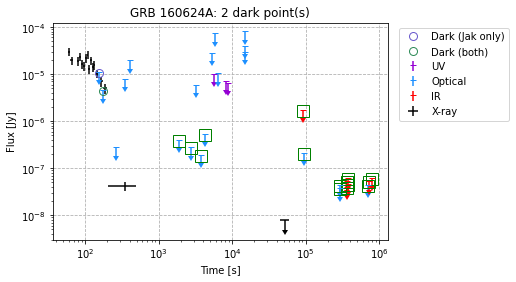

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1009,160601A,688452,Gemini North,GMOS,r,6224.52000,55080.0,23.69,0.05,GCN 19492,0.02,0.045192,23.69 ± 0.05,1.2650364239111216e-06 ± 5.8257080235844905e-08
1010,160601A,NaN,DCT,LMI,r,6100.36312,138240.0,25.00,3-sigma,Rastinejad,0.02,0.046634,"25.0 (+inf, -0.0)","3.7903530319510593e-07 (+0.0, -inf)"
1011,160601A,688452,Discovery,LMI,r,6141.12000,138240.0,25.00,inf,GCN 19497,0.02,0.046046,"25.0 (+inf, -0.0)","3.788301792536111e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


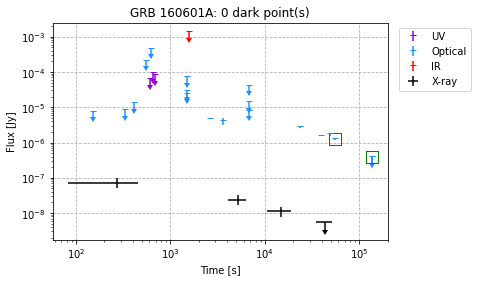

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1035,160411A,682339,La Silla,GROND,g',4504.49,27900.0,23.7,UL,GCN 19292,0.02,0.069583,"23.7 (+inf, -0.0)","1.2819152419881508e-06 (+0.0, -inf)"
1036,160411A,682339,La Silla,GROND,r',6097.98,27900.0,23.9,UL,GCN 19292,0.02,0.046668,"23.9 (+inf, -0.0)","1.0439829551160587e-06 (+0.0, -inf)"
1037,160411A,682339,La Silla,GROND,i',7604.74,27900.0,23.1,UL,GCN 19292,0.02,0.033045,"23.1 (+inf, -0.0)","2.1539934621973035e-06 (+0.0, -inf)"
1042,160411A,NaN,Gemini-S,GMOS,i,7719.34,29376.0,23.3,0.2,Rastinejad,0.02,0.032254,23.3 ± 0.2,1.7903077386263776e-06 ± 3.2978687286663824e-07
1043,160411A,NaN,ESO,MPG,g 0,4504.49,29376.0,23.6,3-sigma,Rastinejad,0.02,0.069583,"23.6 (+inf, -0.0)","1.4055921121436194e-06 (+0.0, -inf)"
1044,160411A,NaN,ESO,MPG,r 0,6097.98,29376.0,23.8,3-sigma,Rastinejad,0.02,0.046668,"23.8 (+inf, -0.0)","1.1447045474298854e-06 (+0.0, -inf)"
1045,160411A,NaN,ESO,MPG,i0,7604.74,29376.0,23.1,3-sigma,Rastinejad,0.02,0.033045,"23.1 (+inf, -0.0)","2.1539934621973035e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


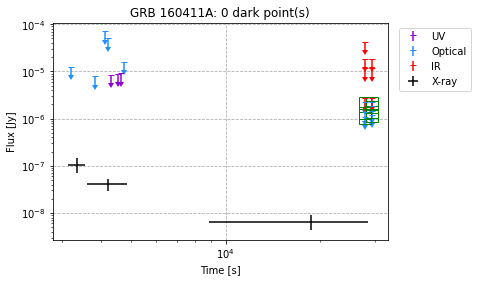

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1051,160410A,NaN,NOT,ALFSOC,r,6330.81,145152.0,25.0,3-sigma,Rastinejad,0.02,0.044047,"25.0 (+inf, -0.0)","3.7813344059294365e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


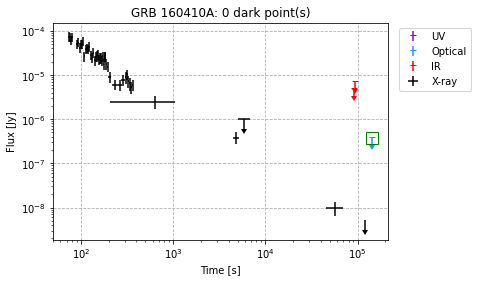

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1061,160408A,682059,Gemini North,GMOS,r,6224.52,3480.0,24.5,NaN,GCN 19262,0.03,0.067788,"24.5 (+nan, -nan)","6.125498260874318e-07 (+nan, -nan)"
1062,160408A,NaN,Gemini-N,GMOS,r,6224.52,4320.0,24.8,0.1,Rastinejad,0.03,0.067788,24.8 ± 0.1,4.646665616579532e-07 ± 4.279737192345606e-08
1063,160408A,682059,Yunnan,GMG,R,6695.58,32400.0,23.3,UL,GCN 19270,0.03,0.060820,"23.3 (+inf, -0.0)","1.8380368354096547e-06 (+0.0, -inf)"
1065,160408A,NaN,Gemini-N,GMOS,r,6224.52,83808.0,25.5,3-sigma,Rastinejad,0.03,0.067788,"25.5 (+inf, -0.0)","2.438604780867041e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


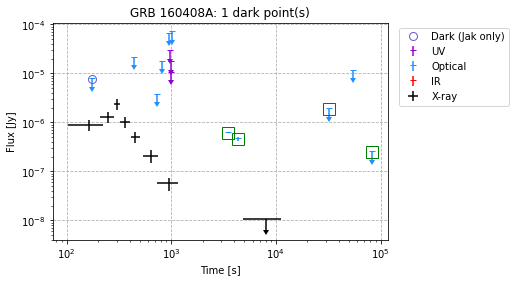

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1068,160303A,NaN,HJT,RATIR,r,6149.311,75168.0,23.7,3-sigma,Rastinejad,0.02,0.045928,"23.7 (+inf, -0.0)","1.2542881592525288e-06 (+0.0, -inf)"
1069,160303A,NaN,HJT,RATIR,i,7531.293,75168.0,23.9,3-sigma,Rastinejad,0.02,0.033566,"23.9 (+inf, -0.0)","1.0314602927868264e-06 (+0.0, -inf)"
1074,160303A,NaN,ESO,MPG,i0,7604.740,149472.0,24.3,3-sigma,Rastinejad,0.02,0.033045,"24.3 (+inf, -0.0)","7.132542708035616e-07 (+0.0, -inf)"
1075,160303A,NaN,ESO,MPG,z 0,8929.330,149472.0,24.4,3-sigma,Rastinejad,0.02,0.025230,"24.4 (+inf, -0.0)","6.45829811473263e-07 (+0.0, -inf)"
1076,160303A,NaN,MMT,MMTCam,r,6122.940,336960.0,25.6,3-sigma,Rastinejad,0.02,0.046308,"25.6 (+inf, -0.0)","2.1804665804175062e-07 (+0.0, -inf)"
1077,160303A,NaN,MMT,MMTCam,i,7591.200,934848.0,24.5,3-sigma,Rastinejad,0.02,0.033141,"24.5 (+inf, -0.0)","5.933114781977335e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


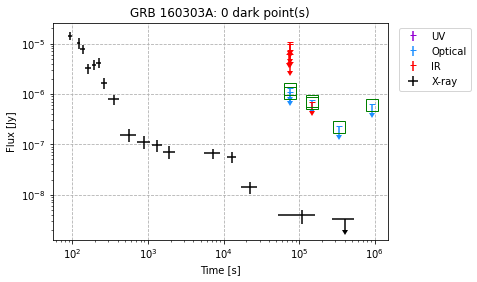

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


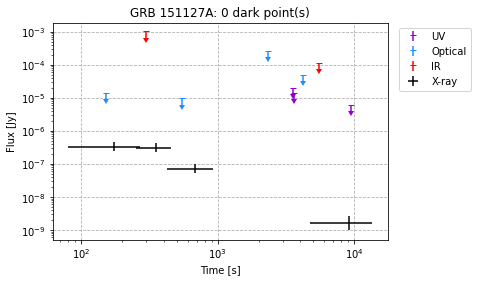

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1135,150831A,NaN,ESO,MPG,g 0,4504.49,45792.0,24.5,3-sigma,Rastinejad,0.11,0.382705,"24.5 (+inf, -0.0)","8.186685224650939e-07 (+0.0, -inf)"
1136,150831A,NaN,ESO,MPG,r 0,6097.98,45792.0,24.2,3-sigma,Rastinejad,0.11,0.256673,"24.2 (+inf, -0.0)","9.609385678355798e-07 (+0.0, -inf)"
1137,150831A,NaN,ESO,MPG,i0,7604.74,45792.0,23.8,3-sigma,Rastinejad,0.11,0.181749,"23.8 (+inf, -0.0)","1.2963610510561376e-06 (+0.0, -inf)"
1138,150831A,NaN,ESO,MPG,z 0,8929.33,45792.0,23.6,3-sigma,Rastinejad,0.11,0.138763,"23.6 (+inf, -0.0)","1.4980674395847475e-06 (+0.0, -inf)"
1140,150831A,653838,La Silla,GROND,g',4504.49,46800.0,24.9,UL,GCN 18219,0.11,0.382705,"24.9 (+inf, -0.0)","5.663802387577992e-07 (+0.0, -inf)"
1141,150831A,653838,La Silla,GROND,r',6097.98,46800.0,24.5,UL,GCN 18219,0.11,0.256673,"24.5 (+inf, -0.0)","7.289464485407323e-07 (+0.0, -inf)"
1142,150831A,653838,La Silla,GROND,i',7604.74,46800.0,23.8,UL,GCN 18219,0.11,0.181749,"23.8 (+inf, -0.0)","1.2963610510561376e-06 (+0.0, -inf)"
1143,150831A,653838,La Silla,GROND,z',8929.33,46800.0,23.8,UL,GCN 18219,0.11,0.138763,"23.8 (+inf, -0.0)","1.246038222915132e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


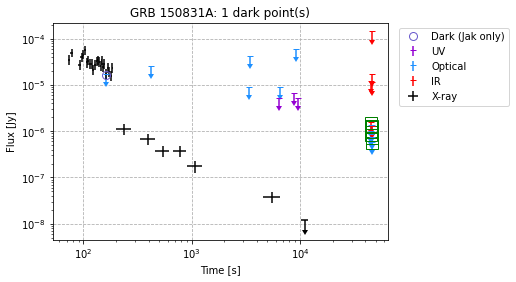

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1191,150424A,638946,Swift,UVOT,UVW2,2085.73,3.146000e+03,23.63,UL,2017A&A...607A..84K,0.06,0.517216,"23.63 (+inf, -0.0)","2.0649652638170865e-06 (+0.0, -inf)"
1196,150424A,638946,Swift,UVOT,UVM2,2245.78,3.376000e+03,23.39,UL,2017A&A...607A..84K,0.06,0.466400,"23.39 (+inf, -0.0)","2.4580249714831e-06 (+0.0, -inf)"
1247,150424A,638946,Swift,UVOT,UVM2,2245.78,7.240600e+04,23.59,UL,2017A&A...607A..84K,0.06,0.466400,"23.59 (+inf, -0.0)","2.0444961197453264e-06 (+0.0, -inf)"
1248,150424A,638946,Swift,UVOT,UVW1,2684.14,9.265700e+04,23.61,UL,2017A&A...607A..84K,0.06,0.344312,"23.610000000000003 (+inf, -0.0)","1.793704371791493e-06 (+0.0, -inf)"
1255,150424A,638946,La Silla,GROND,g′,4504.49,1.561230e+05,23.32,0.1,2017A&A...607A..84K,0.06,0.208748,23.32 ± 0.1,2.067880491987826e-06 ± 1.9045883179777448e-07
1257,150424A,638946,La Silla,GROND,r′,6097.98,1.565820e+05,23.08,0.07,2017A&A...607A..84K,0.06,0.140004,23.08 ± 0.07,2.42118361624424e-06 ± 1.560994764606313e-07
1258,150424A,638946,La Silla,GROND,i′,7604.74,1.565820e+05,23.03,0.13,2017A&A...607A..84K,0.06,0.099136,23.03 ± 0.13,2.4416344533739523e-06 ± 2.9234769693373545e-07
1263,150424A,638946,Swift,UVOT,UVM2,2245.78,1.731860e+05,23.99,UL,2017A&A...607A..84K,0.06,0.466400,"23.990000000000002 (+inf, -0.0)","1.4144457355634012e-06 (+0.0, -inf)"
1264,150424A,638946,Swift,UVOT,UVW1,2684.14,1.779630e+05,23.31,UL,2017A&A...607A..84K,0.06,0.344312,"23.310000000000002 (+inf, -0.0)","2.3645628750922185e-06 (+0.0, -inf)"
1285,150424A,638946,Swift,UVOT,White,3885.68,3.589220e+05,23.40,UL,2017A&A...607A..84K,0.06,0.239055,"23.400000000000002 (+inf, -0.0)","1.9753690239645555e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


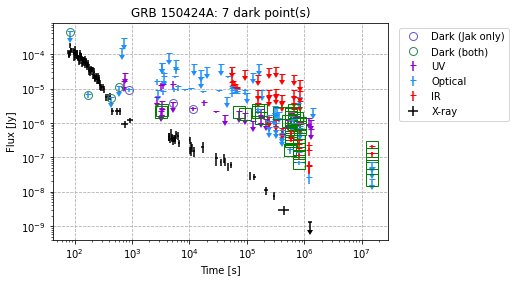

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1346,150423A,638808,La Silla,GROND,g',4504.490,1440.0,23.20,0.2,GCN 17729,0.03,0.104374,23.2 ± 0.2,2.0978568129368264e-06 ± 3.8643950597634684e-07
1347,150423A,638808,La Silla,GROND,r',6097.980,1440.0,23.10,0.2,GCN 17729,0.03,0.070002,23.1 ± 0.2,2.228573631727364e-06 ± 4.1051843384440247e-07
1355,150423A,638808,Swift,UVOT,UVW2,2085.730,3432.0,23.33,3-sigma,GCN 17739,0.03,0.258608,"23.330000000000002 (+inf, -0.0)","2.1452084535415394e-06 (+0.0, -inf)"
1356,150423A,638808,La Silla,GROND,g',4504.490,3480.0,23.20,0.2,GCN 17732,0.03,0.104374,23.2 ± 0.2,2.0978568129368264e-06 ± 3.8643950597634684e-07
1357,150423A,638808,La Silla,GROND,r',6097.980,3480.0,23.10,0.2,GCN 17732,0.03,0.070002,23.1 ± 0.2,2.228573631727364e-06 ± 4.1051843384440247e-07
1368,150423A,NaN,Magellan,IMACS,i,7655.050,8640.0,23.60,0.1,Rastinejad,0.03,0.049052,23.6 ± 0.1,1.3792627569227324e-06 ± 1.2703479453648615e-07
1369,150423A,638808,Johnson,RATIR,r,6149.310,14958.0,23.77,0.23,GCN 17736,0.03,0.068892,23.77 ± 0.23,1.2011102354128455e-06 ± 2.5444058412558523e-07
1370,150423A,638808,Johnson,RATIR,i,7531.290,14958.0,23.62,0.26,GCN 17736,0.03,0.050349,23.62 ± 0.26,1.355706440581289e-06 ± 3.246494618180834e-07
1379,150423A,638808,La Palma,William Herschel Telescope/ACAM,g,4762.280,56822.0,25.30,5-sigma,GCN 17747,0.03,0.097992,"25.3 (+inf, -0.0)","3.0145535989058876e-07 (+0.0, -inf)"
1380,150423A,NaN,WHT,ACAM,g,4762.280,57888.0,25.20,3-sigma,Rastinejad,0.03,0.097992,"25.2 (+inf, -0.0)","3.305392292305281e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


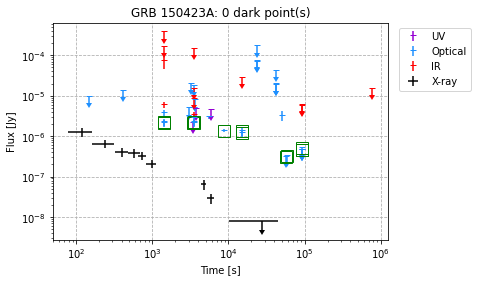

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1388,150120A,NaN,Gemini-N,GMOS,i,7713.83,6912.0,26.0,3-sigma,Rastinejad,0.1,0.161464,"26.0 (+inf, -0.0)","1.677304514639257e-07 (+0.0, -inf)"
1389,150120A,NaN,Gemini-N,GMOS,r,6224.52,6912.0,26.1,3-sigma,Rastinejad,0.1,0.225960,"26.1 (+inf, -0.0)","1.6233424875082073e-07 (+0.0, -inf)"
1392,150120A,NaN,Gemini-N,GMOS,r,6224.52,186624.0,25.7,3-sigma,Rastinejad,0.1,0.225960,"25.7 (+inf, -0.0)","2.3464437929859877e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


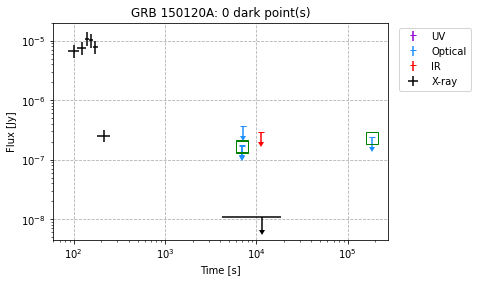

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1401,141212A,NaN,Gemini-N,GMOS,i,7713.83,59616.0,25.2,3-sigma,Rastinejad,0.09,0.145318,"25.2 (+inf, -0.0)","3.452656309860888e-07 (+0.0, -inf)"
1402,141212A,NaN,Gemini-N,GMOS,i,7713.83,151200.0,25.2,3-sigma,Rastinejad,0.09,0.145318,"25.2 (+inf, -0.0)","3.452656309860888e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


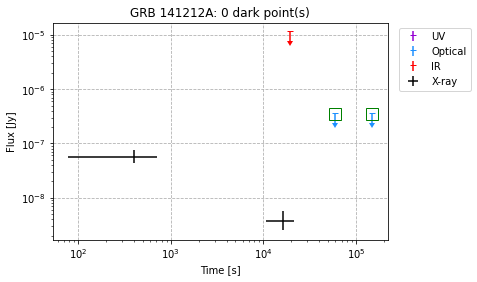

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1463,130912A,NaN,WHT,ACAM,g,4762.280,72576.0,24.1,3-sigma,Rastinejad,0.28,0.914591,"24.1 (+inf, -0.0)","1.9313575700111904e-06 (+0.0, -inf)"
1471,130912A,NaN,HJT,RATIR,r,6149.311,89856.0,23.3,3-sigma,Rastinejad,0.28,0.642988,"23.3 (+inf, -0.0)","3.1421092304797613e-06 (+0.0, -inf)"
1472,130912A,NaN,HJT,RATIR,i,7531.293,89856.0,23.3,3-sigma,Rastinejad,0.28,0.469919,"23.3 (+inf, -0.0)","2.6791310634162193e-06 (+0.0, -inf)"
1477,130912A,NaN,Magellan,FourStar,J,12287.960,1029888.0,23.7,3-sigma,Rastinejad,0.28,0.205050,"23.7 (+inf, -0.0)","1.4522660002839714e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


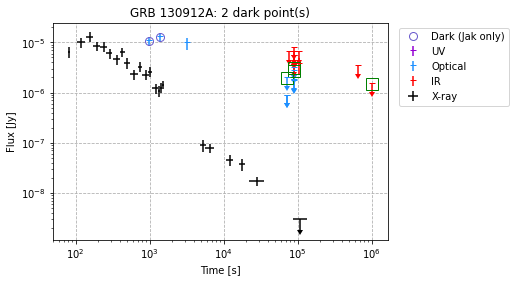

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1479,130822A,NaN,Gemini-N,GMOS,i,7713.83,76032.0,24.5,3-sigma,Rastinejad,0.03,0.048439,"24.5 (+inf, -0.0)","6.017303944519206e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


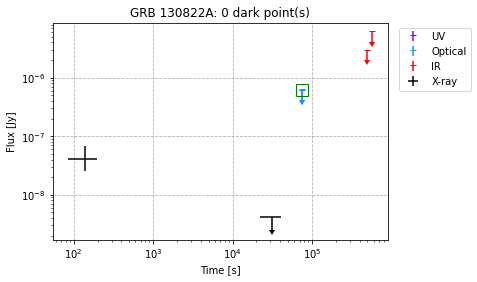

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1510,130313A,NaN,NOT,ALFSOC,i,8466.91,36288.0,23.4,3-sigma,Rastinejad,0.09,0.124337,"23.4 (+inf, -0.0)","1.777301836182935e-06 (+0.0, -inf)"
1512,130313A,NaN,TNG,NaN,r,6562.66,48384.0,25.0,3-sigma,Rastinejad,0.09,0.187306,"25.0 (+inf, -0.0)","4.3146804160028275e-07 (+0.0, -inf)"
1513,130313A,NaN,Gemini-S,GMOS,i,7719.34,53568.0,25.7,3-sigma,Rastinejad,0.09,0.145141,"25.7 (+inf, -0.0)","2.1781246445884493e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,α,B_ox_w_err,B_x,Jak_dark,vdH_dark


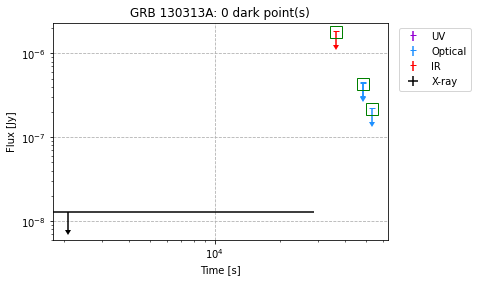

In [35]:
for grb in all_optical[(all_optical["Magnitude"]>=23) & (all_optical["Time (s)"]>=1000) & (all_optical["GRB"].isin(xrt_data["GRB"]))]["GRB"].unique():
    fig, ax = plt.subplots()

    subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()
    dark_points = close_times[close_times["GRB"]==grb]
    of_interest = subset[(subset["Magnitude"]>=23) & (subset["Time (s)"]>=1000) & ~(subset["Time (s)"].isin(results.loc[results["GRB"]==grb,"t_o"]))]
    display(of_interest)
    display(results[(results["GRB"]==grb) & results["t_o"].isin(of_interest["Time (s)"])])

    subset.loc[:,"band"] = ["UV" if wavelength<3000 else "IR" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
    bands = {"UV":["darkviolet","$\lambda<3000$ Å"],"Optical":["dodgerblue","$\lambda<3000$ Å"],"IR":"red"}
    for band,info in bands.items():
        subsubset = subset[subset["band"]==band]
        neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
        pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
        ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                    marker="$—$",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                    uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                    lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)

    subset = xrt_data.loc[xrt_data["GRB"]==grb]
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
    ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subset["SpecFlux"]],
                lolims=[np.isinf(point.plus) for point in subset["SpecFlux"]],
                linestyle="",capthick=0,color="k",label="X-ray")
    
    jak = dark_points[dark_points["Jak_dark"] & ~dark_points["vdH_dark"]]
    vdh = dark_points[dark_points["vdH_dark"] & ~dark_points["Jak_dark"]]
    both = dark_points[dark_points["Jak_dark"] & dark_points["vdH_dark"]]
    
    if len(jak)>0:
        ax.plot(jak["t_o"],[flux.value for flux in jak["F_o"]],
                marker="o",markersize=8,mfc="none",mec="slateblue",
                linestyle="",label="Dark (Jak only)")
    if len(vdh)>0:
        ax.plot(vdh["t_o"],[flux.value for flux in vdh["F_o"]],
                marker="o",markersize=8,mfc="none",mec="goldenrod",
                linestyle="",label="Dark (vdH only)")
    if len(both)>0:
        ax.plot(both["t_o"],[flux.value for flux in both["F_o"]],
                marker="o",markersize=8,mfc="none",mec="seagreen",
                linestyle="",label="Dark (both)")
        
    ax.plot(of_interest["Time (s)"],[flux.value for flux in of_interest["Flux (Jy)"]],"s",mec="green",mfc="none",ms=12)
    
    ax.set(xscale="log",yscale="log",xlabel="Time [s]",ylabel=f"Flux [Jy]",title=f"GRB {grb} lightcurve")
    ax.legend(loc="upper left",bbox_to_anchor=(1.02,1))
    ax.grid(linestyle="--")
    
    plt.title("GRB "+grb+": "+str(close_times["GRB"].tolist().count(grb))+" dark point(s)")
    plt.show()

## Population statistics

### Spectral index distributions

In [36]:
b_ox = [b.value for b in darkest_times["B_ox"]]
oxplus = [0.2 if np.isinf(v.plus) else v.plus for v in darkest_times["B_ox"]]
oxminus = [0.2 if np.isinf(v.minus) else v.minus for v in darkest_times["B_ox"]]
oxuplims = [np.isinf(v.minus) for v in darkest_times["B_ox"]]
oxlolims = [np.isinf(v.plus) for v in darkest_times["B_ox"]]
b_x = [b.value for b in darkest_times["B_x"]]
xplus = [0.2 if np.isinf(v.plus) else v.plus for v in darkest_times["B_x"]]
xminus = [0.2 if np.isinf(v.minus) else v.minus for v in darkest_times["B_x"]]

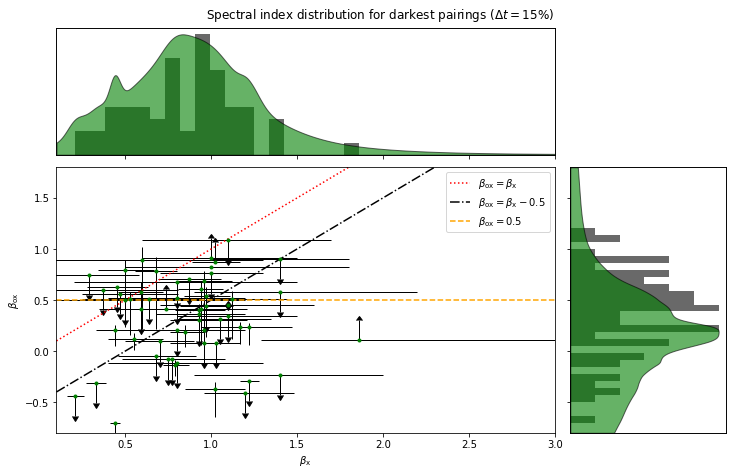

In [37]:
fig = plt.figure(figsize=(12,10))
grid = plt.GridSpec(4, 4, hspace=0.1, wspace=0.1)

ax_main = fig.add_subplot(grid[1:-1, 0:-1])
ax_right = fig.add_subplot(grid[1:-1, -1], xticklabels=[], yticklabels=[])
ax_top = fig.add_subplot(grid[0, 0:-1], xticklabels=[], yticklabels=[])

x = np.linspace(0.1,3,500)
y = np.linspace(-.8,1.8,500)

ax_main.errorbar(b_x,b_ox,xerr=[xminus,xplus],yerr=[oxminus,oxplus],
                 uplims=oxuplims,lolims=oxlolims,
                 linestyle="",marker=".",mfc="g",mec="g",ecolor="k",elinewidth=1,capthick=1)
ax_main.plot(x,x,"r:",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}$")
ax_main.plot(x,x-.5,"k-.",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}-0.5$")
ax_main.plot(x,[.5]*len(x),linestyle="--",color="orange",label=r"$\beta_\mathrm{ox}=0.5$")
ax_main.set(xlim=(x.min(),x.max()),ylim=(y.min(),y.max()),
            xlabel=r"$\beta_\mathrm{x}$",ylabel=r"$\beta_\mathrm{ox}$")
ax_main.legend()

# kde = stats.gaussian_kde(pd.Series(b_x)[pd.notna(b_x)])
# density = kde.evaluate(x)
ax_kde_x = ax_top.twinx()
valid_bx = darkest_times["B_x"]
ax_kde_x.fill_between(x,np.sum([bx.pdf(x) for bx in valid_bx],axis=0),facecolor="green",edgecolor="k",alpha=.6)
ax_kde_x.set_ylim(0)
ax_kde_x.set_yticks([])
ax_top.hist(b_x,19,orientation='vertical', color="dimgrey")
ax_top.set_yticks([])
ax_top.set_xlim(ax_main.get_xlim())

# kde = stats.gaussian_kde(pd.Series(b_ox)[pd.notna(b_x)])
# density = kde.evaluate(y)
ax_kde_y = ax_right.twiny()
valid_box = []
for i,row in darkest_times.iterrows():
    if np.isfinite(row["B_ox"].minus):
        neg = row["B_ox"].minus
    else:
        neg = 1
    if np.isfinite(row["B_ox"].plus):
        pos = row["B_ox"].plus
    else:
        pos = 1
    if np.isfinite(row["B_ox"].value):
        valid_box.append(AsymmetricUncertainty(row["B_ox"].value,pos,neg))
ax_kde_y.fill_betweenx(y,np.sum([box.pdf(y) for box in valid_box],axis=0),facecolor="green",edgecolor="k",alpha=.6)
ax_kde_y.set_xlim(0)
ax_kde_y.set_xticks([])
ax_right.hist(b_ox, 28, orientation='horizontal', color="dimgrey")
ax_right.set_xticks([])
ax_right.set_ylim(ax_main.get_ylim())


fig.suptitle(r"Spectral index distribution for darkest pairings ($\Delta t={}$%)".format(int(max_dt*100)), y=0.91)

plt.show()

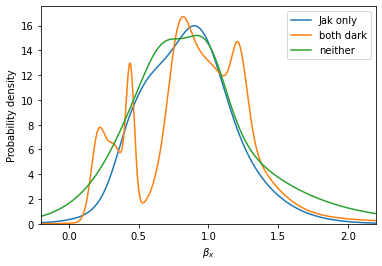

In [59]:
bspace = np.linspace(-0.2,2.2,750)
# only_vdH = darkest_times.loc[darkest_times["vdH_dark"] & ~darkest_times["Jak_dark"]]
only_Jak = darkest_times.loc[darkest_times["Jak_dark"] & ~darkest_times["vdH_dark"]]
bothdark = darkest_times.loc[darkest_times["vdH_dark"] & darkest_times["Jak_dark"]]
# plt.plot(bspace, np.sum([bx.pdf(bspace) for bx in only_vdH["B_x"]],axis=0)/1.773,label="vdH only")
plt.plot(bspace, np.sum([bx.pdf(bspace) for bx in only_Jak["B_x"]],axis=0),label="Jak only")
plt.plot(bspace, np.sum([bx.pdf(bspace) for bx in bothdark["B_x"]],axis=0)/1.2,label="both dark")
plt.plot(bspace, np.sum([bx.pdf(bspace) for bx in darkest_times.loc[~darkest_times["Jak_dark"] & ~darkest_times["vdH_dark"],"B_x"]],axis=0)/1.8,label="neither")
plt.legend()
plt.xlim(-0.2,2.2)
plt.ylim(0)
plt.xlabel(r"$\beta_x$")
plt.ylabel("Probability density")
plt.show()

In [61]:
from code.xrt import grb_list
sGRBs["N_H (intrinsic)"] = [AsymmetricUncertainty(nh) if pd.notna(nh) else np.nan for nh in sGRBs["N_H (intrinsic)"]]
for i in sGRBs.index:
    grb = sGRBs.loc[i,"GRB"]
    print(grb,end=": ")
    if pd.notna(sGRBs.loc[i,"N_H (intrinsic)"]):
        print("already present")
        continue
    try:
        sGRBs.loc[i,"N_H (intrinsic)"],mode = get_columnDensity(grb,sGRBs)
        print("retrieved using",mode)
    except AssertionError:
        print("info doesn't exist")
    except ValueError:
        print("couldn't be parsed")
    except TypeError:
        print("trigger not found")

210413B: info doesn't exist
210410A: already present
210323A: already present
210119A: info doesn't exist
201221D: already present
201214B: info doesn't exist
201006A: already present
200907B: already present
200826A: already present
200716C: already present
200623A: info doesn't exist
200522A: already present
200411A: already present
200405B: info doesn't exist
200325A: trigger not found
200219A: already present
191031D: already present
190719C: already present
190627A: already present
190610A: info doesn't exist
190427A: info doesn't exist
190326A: info doesn't exist
181126A: already present
181123B: already present
180805B: already present
180805A: already present
180727A: already present
180718A: info doesn't exist
180715A: info doesn't exist
180618A: already present
180418A: already present
180402A: already present
180204A: already present
171103A: info doesn't exist
170827A: already present
170822A: already present
170728B: already present
170728A: already present
170524A: alread

Text(0.5, 1.0, 'Hydrogen column densities by category')

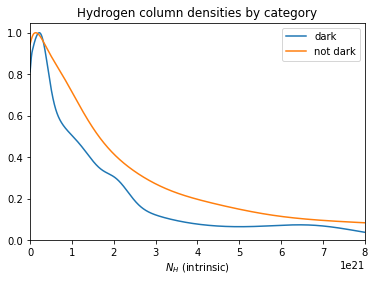

In [62]:
dark_nh = sGRBs.loc[sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"]
# dark_nh = [v for v in dark_nh if v.value>0]
notdark_nh = sGRBs.loc[~sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"]
# notdark_nh = [v for v in notdark_nh if v.value>0]
max_x = 8e21
x = np.linspace(0,max_x,10000)
p_NH_dark = np.sum([nh.pdf(x) for nh in dark_nh],axis=0)
plt.plot(x,p_NH_dark/max(p_NH_dark),label="dark")
p_NH_notdark = np.sum([nh.pdf(x) for nh in notdark_nh],axis=0)
plt.plot(x,p_NH_notdark/max(p_NH_notdark),label="not dark")
plt.xlabel("$N_H$ (intrinsic)")
plt.xlim(0,max_x)
plt.ylim(0)
plt.legend()
plt.title("Hydrogen column densities by category")
# plt.savefig("./products/NH_dists.png",dpi=300,bbox_inches="tight",facecolor="white",transparent=False)

Text(0.5, 1.0, 'Cumulative distributions of Hydrogen column density')

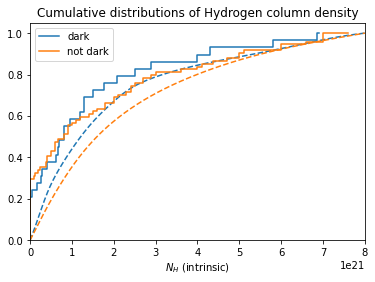

In [65]:
plt.plot(x,np.cumsum(p_NH_dark)/np.sum(p_NH_dark),color="tab:blue",linestyle="--")
plt.plot(x,np.cumsum(p_NH_notdark)/np.sum(p_NH_notdark),color="tab:orange",linestyle="--")
x1 = np.sort([v.value for v  in dark_nh if v.value<max_x])
plt.step(x1, np.linspace(0, 1, len(x1)), where="pre", label="dark")
x2 = np.sort([v.value for v  in notdark_nh if v.value<max_x])
plt.step(x2, np.linspace(0, 1, len(x2)), where="pre", label="not dark")
plt.xlabel("$N_H$ (intrinsic)")
plt.xlim(0,max_x)
plt.ylim(0)
plt.legend()
plt.title("Cumulative distributions of Hydrogen column density")

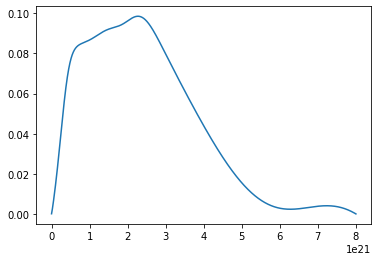

In [68]:
plt.plot(x,np.cumsum(p_NH_dark)/np.sum(p_NH_dark)-np.cumsum(p_NH_notdark)/np.sum(p_NH_notdark))

In [67]:
stats.ks_2samp(sGRBs.loc[~sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"],
               sGRBs.loc[sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"])

KstestResult(statistic=0.21978021978021978, pvalue=0.18314458264566913)

### Observation depth over time

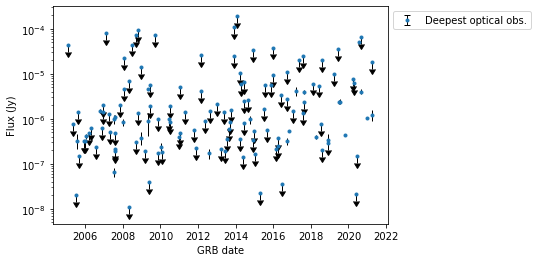

In [70]:
fig = plt.figure()
datestamps = []
deepests = []
for grb,opt in all_optical.dropna(subset=["Flux (Jy)"]).groupby("GRB"):
    yy = grb[:2]
    mm = grb[2:4]
    dd = grb[4:6]
    deepest_obs = min(opt["Flux (Jy)"])
    if pd.notna(deepest_obs):
        datestamps.append(mm+"/"+dd+"/20"+yy)
        deepests.append(deepest_obs)
datestamps = pd.to_datetime(datestamps)
vals = [v.value for v in deepests]
pos = [0.3*v.value if np.isinf(v.plus) else v.plus for v in deepests]
neg = [0.3*v.value if np.isinf(v.minus) else v.minus for v in deepests]
plt.errorbar(datestamps,[d.value for d in deepests],yerr=(neg,pos),linestyle="",marker=".",
             ecolor="k",elinewidth=1,label="Deepest optical obs.",
             uplims=[np.isinf(point.minus) for point in deepests],
                lolims=[np.isinf(point.plus) for point in deepests],capsize=0)
#plt.plot(df.Date,df.Value,":",label=r"Log regression (R$^2=%.2f$)"%(r*r))
plt.yscale("log")
plt.ylabel("Flux (Jy)")
plt.xlabel("GRB date")
plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.show()
fig.savefig("./products/deepest_over_time.png",bbox_inches="tight",dpi=300)

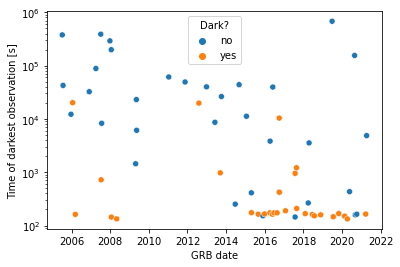

In [71]:
fig,ax = plt.subplots()
datestamps = []
darkest_t = []
cs = []
for grb,data in results.groupby("GRB"):
    yy = grb[:2]
    mm = grb[2:4]
    dd = grb[4:6]
    datestamps.append(mm+"/"+dd+"/20"+yy)
    point = data.loc[data["B_ox"]==data["B_ox"].min(),:]
    darkest_t.append(float(point["t_o"]))
    if all(point["Jak_dark"]) or all(point["vdH_dark"]):
        cs.append("yes")
    else:
        cs.append("no")
    
datestamps = pd.to_datetime(datestamps)
sns.scatterplot(x="Date",y="Time",hue="Dark?",palette="tab10",
                data=pd.DataFrame(zip(datestamps,darkest_t,cs),
                                  columns=["Date","Time","Dark?"]))
plt.xlabel("GRB date")
plt.ylabel("Time of darkest observation [s]")
plt.yscale("log")
plt.show()

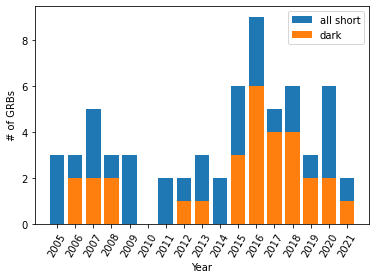

3.7058823529411766 ± 0.5269550843284976 short bursts per year
1.7647058823529411 ± 0.4159451654038515 dark short bursts per year


In [81]:
from code.utilities import addYear
addYear(sGRBs)
addYear(all_optical)
addYear(results)
addYear(dark)

dark_year_counts = {}
all_year_counts = {}

for year in range(2005,2022):
    sample = dark[dark["Year"]==year]
    dark_year_counts[str(year)] = len(sample["GRB"].unique())
        
for year in range(2005,2022):
    sample = results[results["Year"]==year]
    all_year_counts[str(year)] = len(sample["GRB"].unique())

plt.bar(all_year_counts.keys(),all_year_counts.values(),label="all short")
plt.bar(dark_year_counts.keys(),dark_year_counts.values(),label="dark")
plt.xlabel("Year")
plt.ylabel("# of GRBs")
plt.legend()
plt.xticks(rotation=60)
plt.show()
print(np.mean(list(all_year_counts.values())),"±",stats.sem(list(all_year_counts.values())),"short bursts per year")
print(np.mean(list(dark_year_counts.values())),"±",stats.sem(list(dark_year_counts.values())),"dark short bursts per year")

In [84]:
conf = np.zeros((5,5))
tables = (sGRBs,xrt_data,all_optical,results,dark)
names = ["main","xray","optical","matched","dark"]
for grb in sGRBs["GRB"].tolist():
    for i in range(5):
        for j in range(5):
            if i<j:
                conf[i,j] = np.nan
            elif grb in tsables[i].GRB.tolist() and grb in tables[j].GRB.tolist():
                conf[i,j] += 1
conf 

array([[176.,  nan,  nan,  nan,  nan],
       [138., 138.,  nan,  nan,  nan],
       [143., 120., 143.,  nan,  nan],
       [ 60.,  60.,  60.,  60.,  nan],
       [ 30.,  30.,  30.,  30.,  30.]])

Text(0.5, 1.0, 'Number of sGRBs')

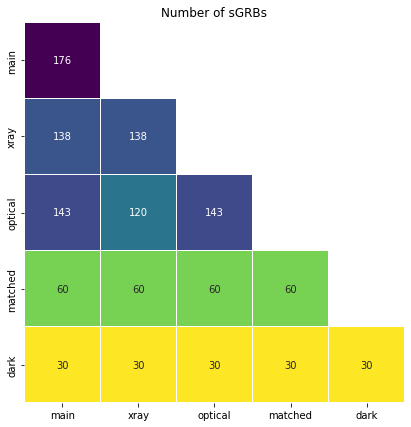

In [85]:
fig,ax = plt.subplots(figsize=(7,7))
sns.heatmap(data=conf,annot=True,fmt="g",
            cmap="viridis_r",cbar=False,
            xticklabels=names,
            yticklabels=names,
            square=True,linewidths=0.1,ax=ax)
for label in ax.yaxis.get_ticklabels():
    label.set_verticalalignment('center')
plt.title("Number of sGRBs")

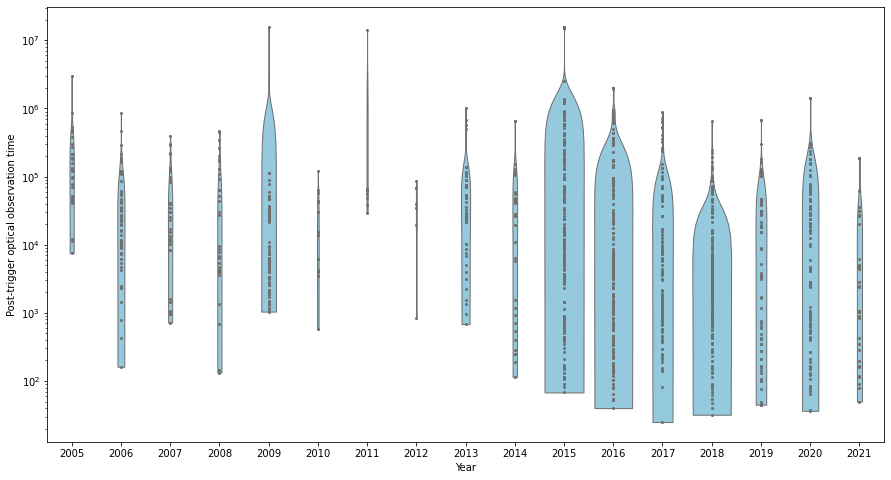

In [73]:
fig,ax = plt.subplots(figsize=(15,8))
sns.violinplot(x="Year",y="Time (s)",data=all_optical,color="skyblue",linewidth=1,
               scale="count",cut=0,bw=0.5,inner="point",ax=ax)
plt.ylabel("Post-trigger optical observation time")
plt.yscale("log")
# plt.ylim(10,1e6)

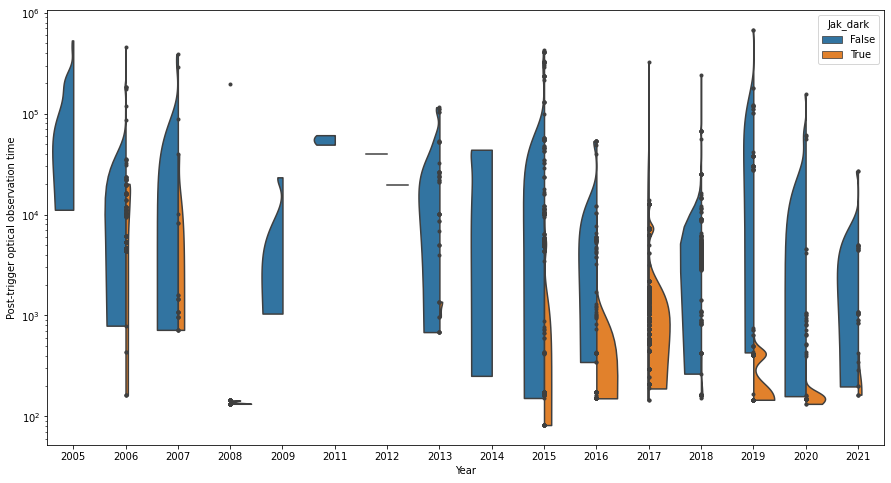

In [74]:
fig,ax = plt.subplots(figsize=(15,8))
sns.violinplot(x="Year",y="t_o",data=results[(results["t_o"]<1e6) & (results["Year"]>2004)],
               scale="count",inner="point",cut=0,hue="Jak_dark",split=True,ax=ax)
plt.ylabel("Post-trigger optical observation time")
plt.yscale("log")
#plt.ylim(1,1e5)

## Illustrative example plot

GRB                                                     160821B
t_o                                                       172.8
dt%                                                    0.136648
nu_o                                        771531515719256.375
F_o                         3.6283672713831243e-06 (+0.0, -inf)
nu_x          4.1880632448032506e+17 (+1.9991731172900093e+1...
F_x           3.602380161441523e-05 (+6.338991984438878e-06,...
B_ox          -0.36453469960571955 (+0.05489544039818211, -inf)
α                                                          2.11
B_ox_w_err    -0.36453469960571955 (+0.12957377603367606, -inf)
B_x                           1.2000000000000002 (+0.28, -0.24)
Jak_dark                                                   True
vdH_dark                                                   True
Name: 1315, dtype: object

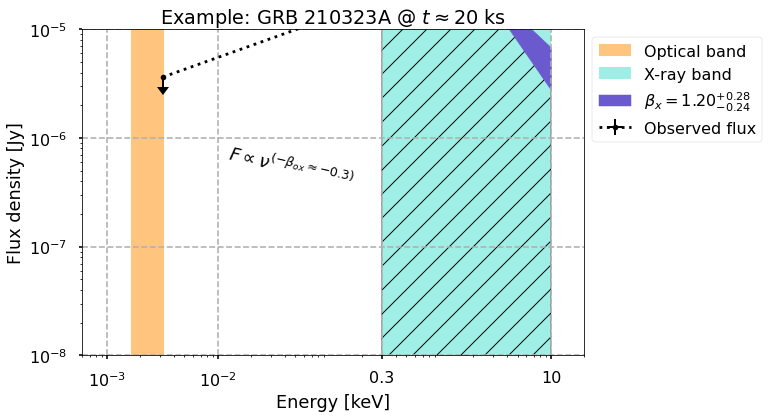

In [26]:
display(results.loc[1315,])
E_range = np.logspace(np.log10(0.3),np.log10(10),100)
beta = results.loc[1315,"B_x"]
E_o = results.loc[1315,"nu_o"]*6.62607015e-34/1.6021773e-16
E_x = results.loc[1315,"nu_x"]*6.62607015e-34/1.6021773e-16
F_o = results.loc[1315,"F_o"]
F_x = results.loc[1315,"F_x"]
spectrum = E_range**-beta.value
scale = F_x.value/spectrum[len(spectrum)//2]
spectrum = scale * spectrum
spec1 = E_range**-beta.maximum
scale1 = F_x.value/spec1[len(spec1)//2]
spec1 = scale1 * spec1
spec2 = E_range**-beta.minimum
scale2 = F_x.value/spec2[len(spec2)//2]
spec2 = scale2 * spec2

plt.style.use("seaborn-poster")
fig,ax = plt.subplots(figsize=(9,6),facecolor="none")

plt.fill_between([0.003262755,0.0016531293],[1,1],alpha=0.5,fc="darkorange",label="Optical band")
plt.fill_between([0.3,10],[1,1],alpha=0.5,fc="turquoise",label="X-ray band")
plt.errorbar([E_o,E_x.value],[F_o.value,F_x.value],xerr=[(0,E_x.minus),(0,E_x.plus)],
             yerr=[(7e-7,F_x.minus),(0,F_x.plus)],
             uplims=[1,0],capsize=0,elinewidth=2,marker=".",linestyle=":",color="k",label="Observed flux")
plt.fill_between(E_range,spectrum,fc="none",ec="k",hatch="/")
plt.fill_between(E_range,spec1,spec2,color="slateblue",label="$\\beta_x=%.2f_{-%.2f}^{+%.2f}$" %(beta.value,beta.minus,beta.plus))
plt.text(1.2e-2,3.5e-7,r"$F\propto\nu^{(-\beta_{ox}\approx\mathrm{-0.3})}$",size=18,rotation=-13)

plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.grid(linestyle="--")
plt.xlim(6e-4,20)
plt.ylim(1e-8,1e-5)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.001,0.01,0.3,10])
plt.gca().set_xticklabels(["$10^{-3}$","$10^{-2}$",0.3,10])
plt.title(r"Example: GRB 210323A @ $t\approx20$ ks")
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density [Jy]")
fig.savefig("./products/160624A.png",bbox_inches="tight",dpi=300)

## To-do

- compare $\beta_x$ distributions between vdH/Jakobsson dark bursts
    - dark between each method
    - dark vs non-dark for each method
- for dark but have optical detections, estimate extinctions ($A_v$)
    - if $\beta_x = \beta_{ox}$ (straight spectrum)
    - if it is -0.5 (assumed dark)
- $N_H$ vs. $\beta_{ox}$ plot and vs. $A_v$
- distribution of $N_H$: are dark mostly at the high end?
- deepest observation of each GRB over time -- have we gotten better at chasing them?
    - some indicator of how early we catch them?
    - at what time are GRBs dark?
- where are my early-time observations from? 
    - check David's tables
    - check Rastinejad, Fong sources
- interpolate XRT light curve to make data matches: does that get us more dark bursts?

### Project status

- finalize 'quantification' of early-time behavior (uninterestingly dark)
    - extra emission in xrays that makes it technically dark but not in the way we care about
- table: total # of sGRBs, # with xray detections, # with optical followup, # with temporally matched (at multiple % values), # dark, # interestingly dark
- fraction is # interestinly dark out of # with optical observations
    - different aspects to this: influence of using big telescopes, getting on it early, progress over the years, etc.
- of the ones that are interestingly dark, what can we say?
- 

### Paper structure
- GRBs two flavors: long/short
- shortly after discovery of afterglow, there were some that were optically dark. even in very fast followup there were some that were not found $\to$ led to classfication scheme for optical darkness where we quantify what we expect to see in optical based on xray. two methods based on what we expect from synchotron spectrum $\to p$. in long GRBs significant fraction due to host galaxy extinction, redshift, extra emission, etc. hasn't been done systematically for sGRBs. that's what we do here
- drill down to these are the interesting ones
- 2 part discussion: darkness in individual GRBs and then darkness in the short GRB population
    - darkness rate, comparison to long GRBs, what makes certain ones dark (characteristics), has rate changed over time
- properties of those and population as a whole in terms of stuff